In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div']#.round(2)# + df['R']*0.13


In [3]:
df['ml_outcomes'].describe()

count    1000000.000000
mean           0.524683
std            0.197853
min            0.028493
25%            0.385027
50%            0.505615
75%            0.661109
max            1.241547
Name: ml_outcomes, dtype: float64

In [4]:
df['T']

0         67
1         46
2         79
3         45
4         63
          ..
999995    48
999996    39
999997    51
999998    43
999999    44
Name: T, Length: 1000000, dtype: int64

In [5]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [6]:
FRAC_ADMIT

A    0.485046
dtype: float64

In [7]:
len(df)

1000000

<AxesSubplot:>

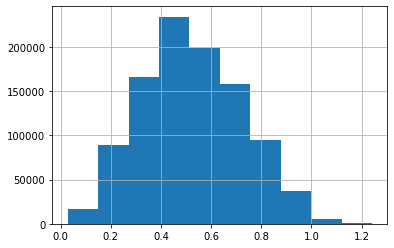

In [8]:
df['ml_outcomes'].hist()

In [9]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
601095,0,10,0.028493,11,10,-3.670390,-3.529184,0,0
724501,0,10,0.028493,8,10,-3.906891,-3.529184,0,0
87558,0,10,0.028493,9,10,-3.828057,-3.529184,0,0
275905,0,11,0.030758,8,11,-3.906891,-3.450350,0,0
937351,0,12,0.033198,11,12,-3.670390,-3.371517,0,0
...,...,...,...,...,...,...,...,...,...
897432,1,106,1.228517,106,121,3.818789,5.221331,1,1
992959,1,107,1.230113,107,124,3.897623,5.457832,1,1
934719,1,107,1.230113,107,124,3.897623,5.457832,1,1
792897,1,108,1.231593,108,125,3.976456,5.536665,1,1


In [10]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [11]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [12]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [13]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [14]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,220,0,0,10,0.085480,3,0.000000
121,214,121,1,8,0.539413,2,0.000000
122,212,122,1,9,0.813866,3,0.000000
123,199,123,1,10,1.364974,5,0.000000
124,211,124,1,11,0.824502,3,0.000000
125,188,125,1,12,3.598614,13,0.000000
120,217,120,1,7,0.268240,1,0.000000
119,218,119,1,6,0.266881,1,0.000000
1,221,1,0,11,0.030758,1,0.000000
3,216,3,0,13,0.429877,12,0.000000


In [15]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [16]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
119,218,119,1,6,0.266881,1,0.000000,0.000001
120,217,120,1,7,0.268240,1,0.000000,0.000001
121,214,121,1,8,0.539413,2,0.000000,0.000002
122,212,122,1,9,0.813866,3,0.000000,0.000003
123,199,123,1,10,1.364974,5,0.000000,0.000005
124,211,124,1,11,0.824502,3,0.000000,0.000003
125,188,125,1,12,3.598614,13,0.000000,0.000013
126,186,126,1,13,4.742190,17,0.058824,0.000017
127,180,127,1,14,7.875083,28,0.142857,0.000028
128,171,128,1,15,14.470229,51,0.137255,0.000051


In [17]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,100001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.27642 309840.5764083718
0.27643 309841.97438718093
0.27644 309843.3732738036
0.27645000000000003 309844.7730684702
0.27646000000000004 309846.1737714105
0.27647000000000005 309847.5753828531
0.27648 309848.9779030285
0.27649 309850.38133216667
0.2765 309851.7856704963
0.27651000000000003 309853.19091824937
0.27652000000000004 309854.5970756543
0.27653 309856.00414294266
0.27654 309857.4121203434
0.27655 309858.82100808737
0.27656000000000003 309860.02077218756
0.27657000000000004 309861.20543369313
0.27658000000000005 309862.39099330944
0.27659 309863.5774512634
0.2766 309864.76480778214
0.27661 309865.953063094
0.27662000000000003 309867.14221742476
0.27663000000000004 309868.33227100404
0.27664 309869.5232240581
0.27665 309870.71507681644
0.27666 309871.7737897679
0.27667 309872.82475621445
0.27668000000000004 309873.87661247014
0.27669000000000005 309874.9293587605
0.2767 309875.98299531033
0.27671 309877.03752234665
0.27672 309878.0929400928
0.27673000000000003 309879.14924877725

0.27911 310051.9639769646
0.27912000000000003 310052.66752356704
0.27913000000000004 310053.371981241
0.27914 310054.0773502216
0.27915 310054.78363074514
0.27916 310055.4908230464
0.27917000000000003 310056.1989273625
0.27918000000000004 310056.907943929
0.27919000000000005 310057.61787298176
0.2792 310058.3287147571
0.27921 310059.0404694908
0.27922 310059.7531374198
0.27923000000000003 310060.4667187806
0.27924000000000004 310061.18121381
0.27925 310061.8966227426
0.27926 310062.6129458174
0.27927 310063.3301832702
0.27928000000000003 310064.0483353373
0.27929000000000004 310064.76740225684
0.27930000000000005 310065.48738426424
0.27931 310066.2082815978
0.27932 310066.9300944942
0.27933 310067.6528231909
0.27934000000000003 310068.37646792503
0.27935000000000004 310069.10102893406
0.27936 310069.8265064553
0.27937 310070.55290072586
0.27938 310071.2802119844
0.27939 310072.00844046834
0.27940000000000004 310072.7375864147
0.27941000000000005 310073.4676500629
0.27942 310074.1986316

0.28179000000000004 310159.82242920663
0.28180000000000005 310159.94165928464
0.28181 310160.06165166164
0.28182 310160.1824065203
0.28183 310160.30392404273
0.28184000000000003 310160.4262044105
0.28185000000000004 310160.54924780666
0.28186 310160.6730544128
0.28187 310160.79762441147
0.28188 310160.9229579852
0.28189000000000003 310161.04905531637
0.28190000000000004 310161.1759165874
0.28191000000000005 310161.30354198074
0.28192 310161.4319316792
0.28193 310161.53690424876
0.28194 310161.6004070953
0.28195000000000003 310161.6646718181
0.28196000000000004 310161.7296985999
0.28197 310161.79548762186
0.28198 310161.86203906697
0.28199 310161.9279801429
0.28200000000000003 310161.99386754964
0.28201000000000004 310162.06051782815
0.28202000000000005 310162.12793116085
0.28203 310162.1961077302
0.28204 310162.2650477186
0.28205 310162.3347513093
0.28206000000000003 310162.40521868475
0.28207000000000004 310162.4764500274
0.28208 310162.5484455206
0.28209 310162.62120534666
0.2821 310

0.28443 310190.0293884436
0.28444 310190.20650192385
0.28445000000000004 310190.3844224107
0.28446000000000005 310190.5631501006
0.28447 310190.7426851903
0.28448 310190.92302787764
0.28449 310191.1041783589
0.28450000000000003 310191.286136831
0.28451000000000004 310191.46890349174
0.28452000000000005 310191.65247853816
0.28453 310191.83686216763
0.28454 310192.02205457684
0.28455 310192.2080559637
0.28456000000000004 310192.39486652665
0.28457000000000005 310192.58248646243
0.28458 310192.77091596695
0.28459 310192.9601552409
0.2846 310193.1502044805
0.28461000000000003 310193.34106388374
0.28462000000000004 310193.5327336475
0.28463000000000005 310193.7252139718
0.28464 310193.91850505304
0.28465 310194.1126070897
0.28466 310194.30752027995
0.28467000000000003 310194.5032448226
0.28468000000000004 310194.6997809148
0.28469 310194.8971287558
0.2847 310195.09528854373
0.28471 310195.2942604764
0.28472000000000003 310195.49404475285
0.28473000000000004 310195.69464157225
0.284740000000

0.28717000000000004 310264.9720528219
0.28718000000000005 310265.33460764174
0.28719 310265.69802531536
0.2872 310266.0623060575
0.28721 310266.4274500835
0.28722000000000003 310266.79345760803
0.28723000000000004 310267.16032884864
0.28724000000000005 310267.52806401905
0.28725 310267.8966633356
0.28726 310268.26612701366
0.28727 310268.63645526965
0.28728000000000004 310269.00764831906
0.28729000000000005 310269.37970637734
0.2873 310269.75262966065
0.28731 310270.1264183859
0.28732 310270.50107276783
0.28733000000000003 310270.87659302336
0.28734000000000004 310271.25297936925
0.28735000000000005 310271.63023202127
0.28736 310272.0083511958
0.28737 310272.3873371095
0.28738 310272.7671899794
0.28739000000000003 310273.1479100211
0.28740000000000004 310273.52949745196
0.28741 310273.9119524886
0.28742 310274.29527534795
0.28743 310274.67946624686
0.28744000000000003 310275.0645254026
0.28745000000000004 310275.45045303146
0.28746000000000005 310275.83724935184
0.28747 310276.22491457

0.28988 310393.2271365318
0.28989000000000004 310393.80860269925
0.28990000000000005 310394.3909924517
0.28991 310394.97430602444
0.28992 310395.55854365375
0.28993 310396.14370557555
0.28994000000000003 310396.72979202535
0.28995000000000004 310397.3168032394
0.28996000000000005 310397.90473945375
0.28997 310398.4936009048
0.28998 310399.08338782855
0.28999 310399.674100462
0.29000000000000004 310400.265739041
0.29001000000000005 310400.8583038025
0.29002 310401.45179498213
0.29003 310402.0462128181
0.29004 310402.64155754657
0.29005000000000003 310403.2378294036
0.29006000000000004 310403.8350286271
0.29007000000000005 310404.43315545353
0.29008 310405.0322101209
0.29009 310405.60119255865
0.2901 310406.16648784827
0.29011000000000003 310406.73270959355
0.29012000000000004 310407.299858031
0.29013 310407.8679333981
0.29014 310408.4369359321
0.29015 310409.006865869
0.29016000000000003 310409.5777234477
0.29017000000000004 310410.1495089037
0.29018000000000005 310410.7222224757
0.2901

0.29258 310420.10565392027
0.29259 310419.9280931217
0.2926 310419.7511944178
0.29261000000000004 310419.5749579479
0.29262000000000005 310419.39938385284
0.29263 310419.22447227326
0.29264 310419.05022334843
0.29265 310418.8766372177
0.29266000000000003 310418.703714023
0.29267000000000004 310418.5314539027
0.29268000000000005 310418.35985699785
0.29269 310418.18892344966
0.2927 310418.0186533972
0.29271 310417.84904698096
0.29272000000000004 310417.68010434194
0.29273000000000005 310417.51182561985
0.29274 310417.3442109551
0.29275 310417.1772604893
0.29276 310417.0109743618
0.29277000000000003 310416.8453527138
0.29278000000000004 310416.6803956859
0.29279000000000005 310416.51610341854
0.2928 310416.3524760528
0.29281 310416.1895137289
0.29282 310416.0272165875
0.29283000000000003 310415.8655847704
0.29284000000000004 310415.70461841783
0.29285 310415.54431767046
0.29286 310415.3846826696
0.29287 310415.2257135557
0.29288000000000003 310415.0674104712
0.29289000000000004 310414.909

0.29533000000000004 310391.90135593095
0.29534000000000005 310391.88013769564
0.29535 310391.85962163785
0.29536 310391.8398079102
0.29537 310391.8206966613
0.29538000000000003 310391.8022880455
0.29539000000000004 310391.7845822134
0.29540000000000005 310391.7675793164
0.29541 310391.75127950514
0.29542 310391.73568293365
0.29543 310391.7207897507
0.29544000000000004 310391.70660011
0.29545000000000005 310391.6931141624
0.29546 310391.6803320612
0.29547 310391.66825395543
0.29548 310391.65687999886
0.29549000000000003 310391.64621034375
0.29550000000000004 310391.63624514063
0.29551000000000005 310391.626984543
0.29552 310391.6184287024
0.29553 310391.6105777703
0.29554 310391.60343189916
0.29555000000000003 310391.59699124197
0.29556000000000004 310391.59125594987
0.29557 310391.58622617525
0.29558 310391.58190207137
0.29559 310391.5782837895
0.29560000000000003 310391.57537148305
0.29561000000000004 310391.5731653033
0.29562000000000005 310391.5716654041
0.29563 310391.570871937
0.2

0.29807 310410.70117253374
0.29808 310410.852945473
0.29809 310411.0054622441
0.29810000000000003 310411.15872300987
0.29811000000000004 310411.3127279342
0.29812000000000005 310411.467477181
0.29813 310411.6229709139
0.29814 310411.77920929674
0.29815 310411.93619249295
0.29816000000000004 310412.09392066667
0.29817000000000005 310412.2523939821
0.29818 310412.4116126026
0.29819 310412.5715766921
0.2982 310412.7322864153
0.29821000000000003 310412.8937419354
0.29822000000000004 310413.05594341765
0.29823000000000005 310413.2188910252
0.29824 310413.3825849229
0.29825 310413.5470252746
0.29826 310413.7122122451
0.29827000000000004 310413.87814599817
0.29828000000000005 310414.0448266991
0.29829 310414.2122545115
0.2983 310414.38042960037
0.29831 310414.54935213004
0.29832000000000003 310414.71902226505
0.29833000000000004 310414.88944017066
0.29834000000000005 310415.0606060112
0.29835 310415.2325199512
0.29836 310415.40518215584
0.29837 310415.5785927896
0.29838000000000003 310415.752

0.30069 310475.5925049165
0.3007 310475.941280968
0.30071000000000003 310476.2908460444
0.30072000000000004 310476.64120032225
0.30073 310476.99234397965
0.30074 310477.34427719243
0.30075 310477.69700013794
0.30076 310478.0505129939
0.30077000000000004 310478.4048159367
0.30078000000000005 310478.75990914414
0.30079 310479.1157927932
0.3008 310479.4724670611
0.30081 310479.8299321251
0.30082000000000003 310480.18818816356
0.30083000000000004 310480.54723535245
0.30084000000000005 310480.90707387036
0.30085 310481.2677038944
0.30086 310481.6291256023
0.30087 310481.9913391724
0.30088000000000004 310482.3543447814
0.30089000000000005 310482.718142608
0.3009 310483.08273282927
0.30091 310483.4481156234
0.30092 310483.8142911688
0.30093000000000003 310484.18125964265
0.30094000000000004 310484.54902122385
0.30095000000000005 310484.9175760899
0.30096 310485.286924419
0.30097 310485.65706638974
0.30098 310486.0280021799
0.30099000000000004 310486.39973196835
0.30100000000000005 310486.7722

0.30339000000000005 310530.63039628556
0.3034 310530.61967327545
0.30341 310530.6096647339
0.30342 310530.60037081497
0.30343000000000003 310530.5917916732
0.30344000000000004 310530.583927462
0.30345 310530.57677833695
0.30346 310530.57034445176
0.30347 310530.5646259614
0.30348 310530.55962302024
0.30349000000000004 310530.55533578264
0.30350000000000005 310530.55176440347
0.30351 310530.5489090369
0.30352 310530.54676983826
0.30353 310530.5453469622
0.30354000000000003 310530.544640563
0.30355000000000004 310530.54465079634
0.30356000000000005 310530.5453778161
0.30357 310530.54682177823
0.30358 310530.5489828371
0.30359 310530.5518611477
0.30360000000000004 310530.55545686494
0.30361000000000005 310530.55977014464
0.30362 310530.5648011416
0.30363 310530.570550011
0.30364 310530.5770169075
0.30365000000000003 310530.5842019872
0.30366000000000004 310530.5921054053
0.30367000000000005 310530.60072731675
0.30368 310530.61006787757
0.30369 310530.6201272427
0.3037 310530.63090556796
0

0.30598000000000003 310552.1740548587
0.30599000000000004 310552.35366329056
0.30600000000000005 310552.53402767546
0.30601 310552.7151481794
0.30602 310552.89702496916
0.30603 310553.0796582108
0.30604000000000003 310553.2630480713
0.30605000000000004 310553.44719471666
0.30606 310553.6320983136
0.30607 310553.8177590288
0.30608 310554.0041770288
0.30609000000000003 310554.1913524804
0.30610000000000004 310554.37928555073
0.30611000000000005 310554.5679764056
0.30612 310554.7574252124
0.30613 310554.94763213856
0.30614 310555.1385973502
0.30615000000000003 310555.3303210151
0.30616000000000004 310555.52280329977
0.30617 310555.7160443716
0.30618 310555.9100443974
0.30619 310556.1048035444
0.3062 310556.30032198026
0.30621000000000004 310556.496599872
0.30622000000000005 310556.693637387
0.30623 310556.8914346926
0.30624 310557.0899919564
0.30625 310557.2893093457
0.30626000000000003 310557.48938702815
0.30627000000000004 310557.6902251714
0.30628000000000005 310557.89182394306
0.30629

0.30858 310622.20347643504
0.30859000000000003 310622.56784336775
0.30860000000000004 310622.9330113458
0.30861000000000005 310623.298980548
0.30862 310623.66575115436
0.30863 310624.0333233454
0.30864 310624.40169730026
0.30865000000000004 310624.7708731983
0.30866000000000005 310625.1408512206
0.30867 310625.5116315468
0.30868 310625.8832143558
0.30869 310626.2555998294
0.30870000000000003 310626.6287881469
0.30871000000000004 310627.0027794886
0.30872000000000005 310627.37757403497
0.30873 310627.7531719657
0.30874 310628.1295734618
0.30875 310628.50677870377
0.30876000000000003 310628.8847878712
0.30877000000000004 310629.2636011454
0.30878 310629.64321870677
0.30879 310630.0236407358
0.3088 310630.4048674129
0.30881000000000003 310630.7868989198
0.30882000000000004 310631.1697354367
0.30883000000000005 310631.5533771444
0.30884 310631.93782422395
0.30885 310632.323076856
0.30886 310632.70913522184
0.30887000000000003 310633.09599950264
0.30888000000000004 310633.48366987926
0.3088

0.31126000000000004 310749.09507471306
0.31127000000000005 310749.680724528
0.31128 310750.26722552726
0.31129 310750.8545779041
0.3113 310751.44278185384
0.31131000000000003 310752.03183757205
0.31132000000000004 310752.6217452525
0.31133000000000005 310753.2125050916
0.31134 310753.8041172835
0.31135 310754.3965820241
0.31136 310754.98989950784
0.31137000000000004 310755.58406992996
0.31138000000000005 310756.1790934867
0.31139 310756.7749703725
0.3114 310757.3717007843
0.31141 310757.9692849161
0.31142000000000003 310758.5677229637
0.31143000000000004 310759.1670151238
0.31144000000000005 310759.76716159075
0.31145 310760.36816256144
0.31146 310760.97001823084
0.31147 310761.5727287958
0.31148000000000003 310762.17629445094
0.31149000000000004 310762.78071539325
0.3115 310763.3859918186
0.31151 310763.9921239229
0.31152 310764.59911190235
0.31153000000000003 310765.2069559543
0.31154000000000004 310765.8156562735
0.31155000000000005 310766.4252130571
0.31156 310767.0356265012
0.3115

0.31383000000000005 310820.66159204714
0.31384 310820.6289595726
0.31385 310820.5969850317
0.31386000000000003 310820.56566855486
0.31387000000000004 310820.5350102726
0.31388000000000005 310820.5050103159
0.31389 310820.4756688147
0.3139 310820.44698590017
0.31391 310820.4189617025
0.31392000000000003 310820.3915963525
0.31393000000000004 310820.3648899817
0.31394000000000005 310820.33884272
0.31395 310820.3134546982
0.31396 310820.28872604715
0.31397 310820.2646568985
0.31398000000000004 310820.24124738225
0.31399000000000005 310820.21849762957
0.314 310820.19640777184
0.31401 310820.17497793987
0.31402 310820.1542082644
0.31403000000000003 310820.1340988766
0.31404000000000004 310820.11464990827
0.31405000000000005 310820.09586148977
0.31406 310820.07773375214
0.31407 310820.0602668273
0.31408 310820.0434608461
0.31409000000000004 310820.0273159399
0.31410000000000005 310820.01183224
0.31411 310819.997009878
0.31412 310819.9828489854
0.31413 310819.9693496929
0.31414000000000003 310

0.31642000000000003 310834.57193255436
0.31643000000000004 310834.71416573133
0.31644 310834.8570918268
0.31645 310835.0007109805
0.31646 310835.1450233317
0.31647000000000003 310835.2900290205
0.31648000000000004 310835.43572818674
0.31649000000000005 310835.5821209708
0.3165 310835.72920751286
0.31651 310835.8769879524
0.31652 310836.02546242933
0.31653000000000003 310836.1746310848
0.31654000000000004 310836.3244940578
0.31655000000000005 310836.475051489
0.31656 310836.626303519
0.31657 310836.778250288
0.31658000000000003 310836.9308919359
0.31659000000000004 310837.0842286028
0.31660000000000005 310837.2382604303
0.31661 310837.39298755775
0.31662 310837.5484101259
0.31663 310837.70452827524
0.31664000000000003 310837.8613421466
0.31665000000000004 310838.0188518803
0.31666000000000005 310838.17705761694
0.31667 310838.33595949755
0.31668 310838.495557662
0.31669 310838.65585225174
0.31670000000000004 310838.8168434073
0.31671000000000005 310838.9785312697
0.31672 310839.14091597

0.31904000000000005 310890.99368573184
0.31905 310891.283813435
0.31906 310891.5746663886
0.31907 310891.8662447415
0.31908000000000003 310892.1585486421
0.31909000000000004 310892.4515782409
0.31910000000000005 310892.74533368606
0.31911 310893.0398151265
0.31912 310893.33502271207
0.31913 310893.63095659186
0.31914000000000003 310893.92761691497
0.31915000000000004 310894.2250038303
0.31916 310894.5231174879
0.31917 310894.8219580369
0.31918 310895.12152562663
0.31919000000000003 310895.4218204069
0.31920000000000004 310895.72284252633
0.31921000000000005 310896.0245921355
0.31922 310896.32706938375
0.31923 310896.6302744203
0.31924 310896.93420739507
0.31925000000000003 310897.23886845796
0.31926000000000004 310897.5442577583
0.31927000000000005 310897.8503754462
0.31928 310898.15722167114
0.31929 310898.4647965834
0.31930000000000003 310898.7731003336
0.31931000000000004 310899.08213306987
0.31932000000000005 310899.3918949432
0.31933 310899.7023861045
0.31934 310900.01360670256
0.

0.32163 310990.80211167334
0.32164000000000004 310991.28517609736
0.32165000000000005 310991.7690057611
0.32166 310992.2536008241
0.32167 310992.7389614475
0.32168 310993.22508779087
0.32169000000000003 310993.71198001417
0.32170000000000004 310994.1996382783
0.32171000000000005 310994.6880627428
0.32172 310995.17725356796
0.32173 310995.6672109151
0.32174 310996.15793494374
0.32175000000000004 310996.64942581387
0.32176000000000005 310997.141683687
0.32177 310997.63470872334
0.32178 310998.1285010833
0.32179 310998.62306092767
0.32180000000000003 310999.1183884164
0.32181000000000004 310999.60351860605
0.32182000000000005 311000.0860224119
0.32183 311000.5692941401
0.32184 311001.0533339512
0.32185 311001.53814200574
0.32186000000000003 311002.02371846494
0.32187000000000004 311002.5100634897
0.32188 311002.99717724114
0.32189 311003.48505987995
0.3219 311003.9737115678
0.32191000000000003 311004.4631324649
0.32192000000000004 311004.95332273265
0.32193000000000005 311005.4442825325
0

0.32427 311053.8292524293
0.32428 311053.82975123916
0.32429 311053.8308881055
0.32430000000000003 311053.832663149
0.32431000000000004 311053.8350764922
0.32432000000000005 311053.8381282567
0.32433 311053.8418185639
0.32434 311053.84614753595
0.32435 311053.85111529444
0.32436000000000004 311053.8567219614
0.32437000000000005 311053.86296765856
0.32438 311053.8698525081
0.32439 311053.87737663207
0.3244 311053.8855401514
0.32441000000000003 311053.89434318943
0.32442000000000004 311053.9037858674
0.32443000000000005 311053.91386830766
0.32444 311053.9245906323
0.32445 311053.9359529634
0.32446 311053.947955423
0.32447000000000004 311053.9605981334
0.32448000000000005 311053.973881217
0.32449 311053.9878047956
0.3245 311054.0023689921
0.32451 311054.0175739285
0.32452000000000003 311054.0334197265
0.32453000000000004 311054.0499065095
0.32454000000000005 311054.0670343999
0.32455 311054.08480351936
0.32456 311054.1032139908
0.32457 311054.12226593704
0.32458000000000004 311054.1419594

0.32686000000000004 311075.63052648935
0.32687000000000005 311075.80043714767
0.32688 311075.9710184355
0.32689 311076.1422704833
0.3269 311076.31419342104
0.32691000000000003 311076.48678737815
0.32692000000000004 311076.6600524856
0.32693000000000005 311076.83398887265
0.32694 311077.00859667035
0.32695 311077.1838760087
0.32696000000000003 311077.3598270174
0.32697000000000004 311077.53644982685
0.32698000000000005 311077.7137445682
0.32699 311077.8917113712
0.327 311078.07035036583
0.32701 311078.24966168357
0.32702000000000003 311078.4296454536
0.32703000000000004 311078.6103018075
0.32704000000000005 311078.7916308752
0.32705 311078.9736327879
0.32706 311079.156307675
0.32707 311079.339655668
0.32708000000000004 311079.5236768972
0.32709000000000005 311079.708371494
0.3271 311079.8937395885
0.32711 311080.0797813113
0.32712 311080.26649679354
0.32713000000000003 311080.45388616604
0.32714000000000004 311080.64194955927
0.32715000000000005 311080.8306871048
0.32716 311081.02009893

0.32943 311140.38265712315
0.32944 311140.7224434936
0.32945 311141.06293500797
0.32946000000000003 311141.4041318057
0.32947000000000004 311141.74603402475
0.32948000000000005 311142.08864180587
0.32949 311142.4319552868
0.3295 311142.77597460785
0.32951 311143.12069990695
0.32952000000000004 311143.4661313244
0.32953000000000005 311143.8122689991
0.32954 311144.1591130703
0.32955 311144.50666367717
0.32956 311144.85492095904
0.32957000000000003 311145.2038850561
0.32958000000000004 311145.5535561069
0.32959000000000005 311145.90393425187
0.3296 311146.25501962943
0.32961 311146.60681237973
0.32962 311146.95931264234
0.32963000000000003 311147.31252055726
0.32964000000000004 311147.6664362636
0.32965000000000005 311148.02105990093
0.32966 311148.37639160996
0.32967 311148.7324315295
0.32968000000000003 311149.0891797998
0.32969000000000004 311149.4466365608
0.32970000000000005 311149.80480195204
0.32971 311150.1636761137
0.32972 311150.52325918607
0.32973 311150.8835513084
0.329740000

0.33204 311253.4066803614
0.33205 311253.9353355234
0.33206 311254.464733389
0.33207000000000003 311254.99487410707
0.33208000000000004 311255.5257578264
0.33209000000000005 311256.0573846962
0.3321 311256.5897548653
0.33211 311257.12286848354
0.33212 311257.65672569926
0.33213000000000004 311258.19132666243
0.33214000000000005 311258.72667152144
0.33215 311259.2627604265
0.33216 311259.79959352646
0.33217 311260.3371709706
0.33218000000000003 311260.8754929083
0.33219000000000004 311261.41455948964
0.33220000000000005 311261.9543708633
0.33221 311262.49492717965
0.33222 311263.0362285873
0.33223 311263.57827523653
0.33224000000000004 311264.12106727704
0.33225000000000005 311264.6646048582
0.33226 311265.2088881299
0.33227 311265.75391724164
0.33228 311266.299692344
0.33229000000000003 311266.84621358593
0.33230000000000004 311267.3934811174
0.33231000000000005 311267.9414950895
0.33232 311268.4902556509
0.33233 311269.0397629521
0.33234 311269.5900171433
0.33235000000000003 311270.14

0.33465 311308.140885981
0.33466 311308.1774651806
0.33467 311308.21465983574
0.33468000000000003 311308.2524700588
0.33469000000000004 311308.2908959612
0.33470000000000005 311308.32993765565
0.33471 311308.3695952533
0.33472 311308.4098688669
0.33473 311308.45075860823
0.33474000000000004 311308.49226458976
0.33475000000000005 311308.534386923
0.33476 311308.57712572056
0.33477 311308.6204810945
0.33478 311308.6644531575
0.33479000000000003 311308.70893984707
0.33480000000000004 311308.753960603
0.33481000000000005 311308.79959832126
0.33482 311308.8458531133
0.33483 311308.89272509154
0.33484 311308.94021436886
0.33485000000000004 311308.9883210577
0.33486000000000005 311309.03704527003
0.33487 311309.08638711803
0.33488 311309.13634671515
0.33489 311309.18692417303
0.33490000000000003 311309.23811960476
0.33491000000000004 311309.2899331226
0.33492000000000005 311309.3423648393
0.33493 311309.3954148673
0.33494 311309.44908331946
0.33495 311309.5033703086
0.33496000000000004 311309

0.33725000000000005 311338.6556070086
0.33726 311338.8558532526
0.33727 311339.0567449316
0.33728 311339.2582821653
0.33729000000000003 311339.46046507265
0.33730000000000004 311339.6632937735
0.33731000000000005 311339.86676838674
0.33732 311340.07088903233
0.33733 311340.2756558289
0.33734000000000003 311340.48106889677
0.33735000000000004 311340.68712835474
0.33736000000000005 311340.89383432234
0.33737 311341.10118691996
0.33738 311341.309186266
0.33739 311341.5178324812
0.33740000000000003 311341.7271256847
0.33741000000000004 311341.93706599576
0.33742000000000005 311342.1476535349
0.33743 311342.35888842103
0.33744 311342.5707707745
0.33745 311342.783300715
0.33746000000000004 311342.9964783622
0.33747000000000005 311343.2103038358
0.33748 311343.42477725574
0.33749 311343.6398987424
0.3375 311343.8556684151
0.33751000000000003 311344.0720863944
0.33752000000000004 311344.28915279964
0.33753000000000005 311344.5068677513
0.33754 311344.72523136914
0.33755 311344.94424377376
0.33

0.33985000000000004 311412.72457552573
0.33986000000000005 311413.0961484819
0.33987 311413.4683989498
0.33988 311413.84132705635
0.33989 311414.2149329288
0.33990000000000004 311414.5892166945
0.33991000000000005 311414.9641784811
0.33992000000000006 311415.3398184161
0.33993 311415.7161366265
0.33994 311416.09313323937
0.33995000000000003 311416.47080838325
0.33996000000000004 311416.84916218434
0.33997000000000005 311417.22819477157
0.33998 311417.6079062719
0.33999 311417.98829681217
0.34 311418.3693665212
0.34001000000000003 311418.7511155257
0.34002000000000004 311419.1335439546
0.34003000000000005 311419.5166519346
0.34004 311419.9004395933
0.34005 311420.28490705916
0.34006000000000003 311420.67005445977
0.34007000000000004 311421.05588192365
0.34008000000000005 311421.44238957705
0.34009 311421.8295775491
0.3401 311422.217445968
0.34011 311422.60599496105
0.34012000000000003 311422.9952246568
0.34013000000000004 311423.38513518247
0.34014000000000005 311423.7757266671
0.34015 

0.34251000000000004 311535.84316332894
0.34252000000000005 311536.399540278
0.34253 311536.9566297423
0.34254 311537.5144318584
0.34255 311538.0729467625
0.34256000000000003 311538.63217459037
0.34257000000000004 311539.1921154789
0.34258000000000005 311539.7527695636
0.34259 311540.31413698103
0.3426 311540.8762178672
0.34261 311541.4390123591
0.34262000000000004 311542.0025205927
0.34263000000000005 311542.56674270425
0.34264000000000006 311543.1316788302
0.34265 311543.6973291072
0.34266 311544.2636936723
0.34267000000000003 311544.8307726612
0.34268000000000004 311545.39856621047
0.34269000000000005 311545.9670744574
0.3427 311546.53629753814
0.34271 311547.1062355892
0.34272 311547.67688874813
0.34273000000000003 311548.2482571507
0.34274000000000004 311548.8203409342
0.34275000000000005 311549.3931402359
0.34276 311549.96665519156
0.34277 311550.54088593915
0.34278000000000003 311551.1158326146
0.34279000000000004 311551.6914953558
0.34280000000000005 311552.2678742991
0.34281 31

0.34518000000000004 311566.8606958671
0.34519000000000005 311566.97315444076
0.3452 311567.08621733316
0.34521 311567.19988464983
0.34522 311567.3141564979
0.34523000000000004 311567.4290329836
0.34524000000000005 311567.5445142128
0.34525 311567.6606002922
0.34526 311567.77729132853
0.34527 311567.89458742813
0.34528000000000003 311568.01248869736
0.34529000000000004 311568.1309952431
0.34530000000000005 311568.2501071716
0.34531 311568.36982458923
0.34532 311568.4901476034
0.34533 311568.6110763197
0.34534000000000004 311568.73261084565
0.34535000000000005 311568.8547512875
0.34536000000000006 311568.977497752
0.34537 311569.10085034586
0.34538 311569.22480917635
0.34539000000000003 311569.3493743494
0.34540000000000004 311569.47454597265
0.34541000000000005 311569.60032415204
0.34542 311569.7267089951
0.34543 311569.8537006089
0.34544 311569.98129909986
0.34545000000000003 311570.10950457456
0.34546000000000004 311570.23831714067
0.34547000000000005 311570.36773690494
0.34548 311570

0.34779000000000004 311616.16809639207
0.34780000000000005 311616.4365996752
0.34781 311616.70573587186
0.34782 311616.97550509433
0.34783000000000003 311617.2459074559
0.34784000000000004 311617.51694307016
0.34785000000000005 311617.78861205
0.34786 311618.06091450836
0.34787 311618.3338505588
0.34788 311618.6074203142
0.34789000000000003 311618.8816238887
0.34790000000000004 311619.15646139474
0.34791000000000005 311619.43193294597
0.34792 311619.7080386558
0.34793 311619.98477863765
0.34794 311620.26215300476
0.34795000000000004 311620.54016187077
0.34796000000000005 311620.8188053492
0.34797 311621.098083553
0.34798 311621.3779965967
0.34799 311621.6585445927
0.34800000000000003 311621.9397276557
0.34801000000000004 311622.2215458984
0.34802000000000005 311622.5039994349
0.34803 311622.78708837903
0.34804 311623.0708128438
0.34805 311623.35517294356
0.34806000000000004 311623.64016879187
0.34807000000000005 311623.9258005023
0.34808000000000006 311624.2120681896
0.34809 311624.498

0.35039000000000003 311706.7087633011
0.35040000000000004 311707.1237228741
0.35041000000000005 311707.5393461552
0.35042 311707.9556332653
0.35043 311708.3725843249
0.35044000000000003 311708.7901994537
0.35045000000000004 311709.208478773
0.35046000000000005 311709.6274224033
0.35047 311710.0470304654
0.35048 311710.467303079
0.35049 311710.8882403656
0.35050000000000003 311711.3098424461
0.35051000000000004 311711.7321094406
0.35052000000000005 311712.1550414699
0.35053 311712.5786386553
0.35054 311713.0029011172
0.35055000000000003 311713.42782897636
0.35056000000000004 311713.8534223542
0.35057000000000005 311714.27968137106
0.35058 311714.7066061478
0.35059 311715.13419680606
0.3506 311715.5624534663
0.35061000000000003 311715.99137624993
0.35062000000000004 311716.4209652775
0.35063000000000005 311716.8512206704
0.35064 311717.2821425495
0.35065 311717.7137310362
0.35066 311718.1459862519
0.35067000000000004 311718.57890831673
0.35068000000000005 311719.0124973533
0.35069 311719

0.35298 311789.47994458023
0.35299 311789.405311299
0.35300000000000004 311789.33120527334
0.35301000000000005 311789.2576265866
0.35302000000000006 311789.1845753231
0.35303 311789.11205156596
0.35304 311789.0400553986
0.35305000000000003 311788.96858690423
0.35306000000000004 311788.8976461672
0.35307000000000005 311788.8272332703
0.35308 311788.7573482978
0.35309 311788.6879913329
0.3531 311788.61916245916
0.35311000000000003 311788.550861761
0.35312000000000004 311788.4830893212
0.35313000000000005 311788.4158452235
0.35314 311788.3491295522
0.35315 311788.2829423902
0.35316000000000003 311788.2172838223
0.35317000000000004 311788.1521539315
0.35318000000000005 311788.08755280153
0.35319 311788.0234805165
0.3532 311787.9599371606
0.35321 311787.8969228164
0.35322000000000003 311787.83443756896
0.35323000000000004 311787.7724815014
0.35324000000000005 311787.71105469833
0.35325 311787.65015724313
0.35326 311787.5897892196
0.35327000000000003 311787.529950712
0.35328000000000004 3117

0.35561000000000004 311788.2706225062
0.35562000000000005 311788.3375871694
0.35563 311788.40510166355
0.35564 311788.4731660766
0.35565 311788.54178049706
0.35566000000000003 311788.610945013
0.35567000000000004 311788.68065971317
0.35568000000000005 311788.7509246855
0.35569 311788.8217400186
0.3557 311788.89310580044
0.35571 311788.96502212045
0.35572000000000004 311789.0374890659
0.35573000000000005 311789.11050672614
0.35574000000000006 311789.18407518853
0.35575 311789.258194543
0.35576 311789.33286487655
0.35577000000000003 311789.4080862789
0.35578000000000004 311789.48385883804
0.35579000000000005 311789.5601826426
0.3558 311789.637057781
0.35581 311789.71448434214
0.35582 311789.79246241454
0.35583000000000004 311789.87099208677
0.35584000000000005 311789.9500734473
0.35585000000000006 311790.0297065852
0.35586 311790.1098915888
0.35587 311790.1906285469
0.35588000000000003 311790.27191754855
0.35589000000000004 311790.3537586819
0.35590000000000005 311790.43615203653
0.35591

0.3582 311824.2085250448
0.35821000000000003 311824.4206955446
0.35822000000000004 311824.6334393904
0.35823000000000005 311824.84675667493
0.35824 311825.06064749166
0.35825 311825.27511193405
0.35826 311825.4901500963
0.35827000000000003 311825.7057620706
0.35828000000000004 311825.9219479508
0.35829000000000005 311826.13870783057
0.3583 311826.35604180297
0.35831 311826.57394996245
0.35832 311826.7924324014
0.35833000000000004 311827.01148921414
0.35834000000000005 311827.23112049396
0.35835 311827.4513263344
0.35836 311827.67210682883
0.35837 311827.8934620717
0.35838000000000003 311828.1153921555
0.35839000000000004 311828.33789717517
0.35840000000000005 311828.5609772233
0.35841 311828.78463239456
0.35842 311829.0088627816
0.35843 311829.23366847896
0.35844000000000004 311829.4590495802
0.35845000000000005 311829.6850061791
0.35846000000000006 311829.9115383692
0.35847 311830.13864624477
0.35848 311830.36632989993
0.35849000000000003 311830.5945894274
0.35850000000000004 311830.8

0.36078000000000005 311898.11597334285
0.36079000000000006 311898.47638239927
0.3608 311898.837388229
0.36081 311899.1989909295
0.36082000000000003 311899.5611905999
0.36083000000000004 311899.9239873393
0.36084000000000005 311900.2873812455
0.36085 311900.65137241763
0.36086 311901.015960954
0.36087 311901.3811469535
0.36088000000000003 311901.7469305147
0.36089000000000004 311902.1133117362
0.36090000000000005 311902.48029071704
0.36091 311902.8478675556
0.36092 311903.21604235144
0.36093000000000003 311903.58481520263
0.36094000000000004 311903.9541862078
0.36095000000000005 311904.3241554662
0.36096 311904.69472307665
0.36097 311905.065889138
0.36098 311905.43765374925
0.36099000000000003 311905.81001700903
0.36100000000000004 311906.1829790167
0.36101000000000005 311906.55653987103
0.36102 311906.9306996711
0.36103 311907.3054585157
0.36104 311907.68081650406
0.36105000000000004 311908.0567737347
0.36106000000000005 311908.4333303077
0.36107 311908.8104863216
0.36108 311909.188241

0.36342 311930.71505061834
0.36343000000000003 311930.7013363742
0.36344000000000004 311930.6881430351
0.36345000000000005 311930.67547068244
0.36346 311930.6633193965
0.36347 311930.6516892591
0.36348 311930.64058035135
0.36349000000000004 311930.62999275373
0.36350000000000005 311930.61992654746
0.36351000000000006 311930.6103818143
0.36352 311930.6013586349
0.36353 311930.59285709006
0.36354000000000003 311930.5848772615
0.36355000000000004 311930.5774192298
0.36356000000000005 311930.5704830767
0.36357 311930.56406888325
0.36358 311930.5581767305
0.36359 311930.5528067001
0.36360000000000003 311930.5479588729
0.36361000000000004 311930.5436333301
0.36362000000000005 311930.53983015375
0.36363 311930.5365494243
0.36364 311930.53379122354
0.36365000000000003 311930.53155563254
0.36366000000000004 311930.52984273277
0.36367000000000005 311930.5286526056
0.36368 311930.5279853327
0.36369 311930.5278409952
0.3637 311930.52821967425
0.36371000000000003 311930.52912145166
0.36372000000000

0.36599000000000004 311944.3339113797
0.36600000000000005 311944.4556932295
0.36601000000000006 311944.57801738015
0.36602 311944.70088391757
0.36603 311944.82429292746
0.36604000000000003 311944.9482444941
0.36605000000000004 311945.07273870456
0.36606000000000005 311945.1977756434
0.36607 311945.32335539674
0.36608 311945.44947804976
0.36609 311945.576143688
0.36610000000000004 311945.7033523978
0.36611000000000005 311945.83110426366
0.36612000000000006 311945.95939937216
0.36613 311946.0882378087
0.36614 311946.21761965903
0.36615000000000003 311946.34754500835
0.36616000000000004 311946.47801394324
0.36617000000000005 311946.60902654886
0.36618 311946.74058291106
0.36619 311946.8726831154
0.3662 311947.00532724836
0.36621000000000004 311947.1385153951
0.36622000000000005 311947.27224764175
0.36623000000000006 311947.4065240739
0.36624 311947.5413447779
0.36625 311947.67670983926
0.36626000000000003 311947.81261934375
0.36627000000000004 311947.94907337765
0.36628000000000005 311948

0.36852 311992.6631950471
0.36853 311992.92495248606
0.36854000000000003 311993.18727443606
0.36855000000000004 311993.450160987
0.36856000000000005 311993.7136122296
0.36857 311993.9776282541
0.36858 311994.2422091504
0.36859000000000003 311994.5073550089
0.36860000000000004 311994.7730659201
0.36861000000000005 311995.0393419737
0.36862 311995.30618326017
0.36863 311995.5735898704
0.36864 311995.84156189417
0.36865000000000003 311996.1100994221
0.36866000000000004 311996.37920254446
0.36867000000000005 311996.64887135185
0.36868 311996.9191059342
0.36869 311997.1899063826
0.3687 311997.461272787
0.36871000000000004 311997.7332052383
0.36872000000000005 311998.0057038264
0.36873000000000006 311998.27876864234
0.36874 311998.5523997765
0.36875 311998.82659731957
0.36876000000000003 311999.1013613617
0.36877000000000004 311999.3766919939
0.36878000000000005 311999.6525893072
0.36879 311999.92905339104
0.3688 312000.20608433685
0.36881 312000.4836822354
0.36882000000000004 312000.7618471

0.37111000000000005 312072.107888425
0.37112 312071.9588278927
0.37113 312071.81022810127
0.37114 312071.6620891145
0.37115000000000004 312071.51441099786
0.37116000000000005 312071.36719381623
0.37117000000000006 312071.2204376354
0.37118 312071.0741425192
0.37119 312070.9283085333
0.37120000000000003 312070.7829357431
0.37121000000000004 312070.6380242131
0.37122000000000005 312070.49357400846
0.37123 312070.34958519426
0.37124 312070.206057836
0.37125 312070.0629919985
0.37126000000000003 312069.9203877467
0.37127000000000004 312069.77824514627
0.37128000000000005 312069.63656426186
0.37129 312069.4953451592
0.3713 312069.35458790284
0.37131000000000003 312069.21429255826
0.37132000000000004 312069.0744591908
0.37133000000000005 312068.93508786545
0.37134 312068.79617864743
0.37135 312068.6577316021
0.37136 312068.5197467952
0.37137000000000003 312068.382224291
0.37138000000000004 312068.2451641555
0.37139000000000005 312068.10856645356
0.3714 312067.9724312508
0.37141 312067.836758

0.37371000000000004 312048.44335636206
0.37372000000000005 312048.4064068144
0.37373 312048.3699330665
0.37374 312048.3339351856
0.37375 312048.2984132398
0.37376000000000004 312048.2633672976
0.37377000000000005 312048.2287974264
0.37378000000000006 312048.1947036941
0.37379 312048.16108616913
0.3738 312048.1279449193
0.37381000000000003 312048.09528001223
0.37382000000000004 312048.06309151667
0.37383000000000005 312048.03137950035
0.37384 312048.00014403136
0.37385 312047.9693851778
0.37386 312047.93910300784
0.37387000000000004 312047.9092975897
0.37388000000000005 312047.87996899115
0.37389000000000006 312047.8511172801
0.3739 312047.8227425257
0.37391 312047.7948447952
0.37392000000000003 312047.7674241571
0.37393000000000004 312047.7404806796
0.37394000000000005 312047.71401443065
0.37395 312047.6880254791
0.37396 312047.6625138924
0.37397 312047.63747973944
0.37398000000000003 312047.6129230881
0.37399000000000004 312047.58884400665
0.37400000000000005 312047.5652425633
0.37401

0.37624 312054.4460395366
0.37625000000000003 312054.5316680494
0.37626000000000004 312054.6177899709
0.37627000000000005 312054.7044053728
0.37628 312054.79151432664
0.37629 312054.8791169032
0.3763 312054.96721317427
0.37631000000000003 312055.0558032111
0.37632000000000004 312055.1448870849
0.37633000000000005 312055.2344648674
0.37634 312055.32453662984
0.37635 312055.4151024439
0.37636000000000003 312055.5061623805
0.37637000000000004 312055.5977165112
0.37638000000000005 312055.68976490805
0.37639000000000006 312055.78230764205
0.3764 312055.8753447846
0.37641 312055.9688764072
0.37642000000000003 312056.0629025818
0.37643000000000004 312056.1574233796
0.37644000000000005 312056.2524388721
0.37645 312056.3479491309
0.37646 312056.4439542279
0.37647 312056.5404542345
0.37648000000000004 312056.6374492218
0.37649000000000005 312056.7349392622
0.37650000000000006 312056.832924427
0.37651 312056.9314047877
0.37652 312057.03038041596
0.37653000000000003 312057.12985138403
0.3765400000

0.37882000000000005 312092.6040481126
0.37883000000000006 312092.8092661345
0.37884 312093.0149968334
0.37885 312093.2212402847
0.37886000000000003 312093.4279965626
0.37887000000000004 312093.63526574295
0.37888000000000005 312093.84304790036
0.37889 312094.0513431104
0.3789 312094.2601514473
0.37891 312094.4694729872
0.37892000000000003 312094.6793078049
0.37893000000000004 312094.8896559752
0.37894000000000005 312095.1005175732
0.37895 312095.31189267494
0.37896 312095.52378135483
0.37897000000000003 312095.7361836884
0.37898000000000004 312095.9490997507
0.37899000000000005 312096.16252961685
0.379 312096.3764733623
0.37901 312096.5909310625
0.37902 312096.8059027924
0.37903000000000003 312097.0213886277
0.37904000000000004 312097.23738864326
0.37905000000000005 312097.4539029146
0.37906 312097.67093151715
0.37907 312097.8884745261
0.37908000000000003 312098.10653201654
0.37909000000000004 312098.32332610316
0.37910000000000005 312098.53964620497
0.37911000000000006 312098.75648033

0.38139 312099.65161464683
0.3814 312099.5092250789
0.38141 312099.3672736819
0.38142000000000004 312099.2257605153
0.38143000000000005 312099.0846856375
0.38144000000000006 312098.9440491072
0.38145 312098.80385098327
0.38146 312098.66409132467
0.38147000000000003 312098.52477018995
0.38148000000000004 312098.3858876378
0.38149000000000005 312098.2474437271
0.3815 312098.109438517
0.38151 312097.97187206615
0.38152 312097.83474443335
0.38153000000000004 312097.6980556773
0.38154000000000005 312097.5618058571
0.38155000000000006 312097.4259950315
0.38156 312097.29062325973
0.38157 312097.1556906003
0.38158000000000003 312097.0211971123
0.38159000000000004 312096.8871428545
0.38160000000000005 312096.75352788554
0.38161 312096.62035226513
0.38162 312096.4876160518
0.38163 312096.3553193042
0.38164000000000003 312096.223462082
0.38165000000000004 312096.0920444437
0.38166000000000005 312095.9610664483
0.38167 312095.830528155
0.38168 312095.7004296229
0.38169000000000003 312095.570770910

0.38403000000000004 312077.347466142
0.38404000000000005 312077.3085593841
0.38405000000000006 312077.2701034255
0.38406 312077.2320983278
0.38407 312077.1945441517
0.38408000000000003 312077.1574409585
0.38409000000000004 312077.1207888094
0.38410000000000005 312077.0845877658
0.38411 312077.04883788887
0.38412 312077.0135392394
0.38413 312076.97869187925
0.38414000000000004 312076.9442958688
0.38415000000000005 312076.9103512703
0.38416000000000006 312076.87685814453
0.38417 312076.84381655284
0.38418 312076.8112265562
0.38419000000000003 312076.7790882166
0.38420000000000004 312076.7474015946
0.38421000000000005 312076.7161667517
0.38422 312076.6853837498
0.38423 312076.6550526498
0.38424 312076.62517351285
0.38425000000000004 312076.5957464005
0.38426000000000005 312076.5667713746
0.38427000000000006 312076.5382484958
0.38428 312076.510177826
0.38429 312076.4825594259
0.38430000000000003 312076.45539335796
0.38431000000000004 312076.42867968295
0.38432000000000005 312076.4024184626

0.38653000000000004 312080.91424862406
0.38654000000000005 312080.95605877764
0.38655 312080.9983304941
0.38656 312081.04106383753
0.38657 312081.08425887086
0.38658000000000003 312081.12791565753
0.38659000000000004 312081.172034261
0.38660000000000005 312081.2166147449
0.38661 312081.26165717194
0.38662 312081.30716160615
0.38663000000000003 312081.35312811093
0.38664000000000004 312081.39955674886
0.38665000000000005 312081.4464475843
0.38666000000000006 312081.49380068027
0.38667 312081.54161610035
0.38668 312081.5898939082
0.38669000000000003 312081.63863416703
0.38670000000000004 312081.68783694034
0.38671000000000005 312081.7375022917
0.38672 312081.78763028455
0.38673 312081.83822098275
0.38674000000000003 312081.8892744494
0.38675000000000004 312081.9407907483
0.38676000000000005 312081.9927699431
0.38677000000000006 312082.0452120969
0.38678 312082.0981172735
0.38679 312082.15148553695
0.38680000000000003 312082.20531695045
0.38681000000000004 312082.25961157755
0.38682000000

0.38905 312101.36929507315
0.38906 312101.11428739096
0.38907 312100.8596959456
0.38908000000000004 312100.60552079097
0.38909000000000005 312100.35176198237
0.38910000000000006 312100.09841957426
0.38911 312099.8454936215
0.38912 312099.5929841787
0.38913000000000003 312099.34089130105
0.38914000000000004 312099.0892150426
0.38915000000000005 312098.83795545873
0.38916 312098.5871126038
0.38917 312098.33668653324
0.38918 312098.0866773015
0.38919000000000004 312097.8370849634
0.38920000000000005 312097.58790957386
0.38921000000000006 312097.3391511871
0.38922 312097.09080985934
0.38923 312096.84288564423
0.38924000000000003 312096.59537859686
0.38925000000000004 312096.34828877274
0.38926000000000005 312096.10161622614
0.38927 312095.8553610119
0.38928 312095.6095231858
0.38929 312095.3641028016
0.38930000000000003 312095.11909991514
0.38931000000000004 312094.8745145809
0.38932000000000005 312094.6303468539
0.38933 312094.3865967892
0.38934 312094.14326444163
0.38935000000000003 3120

0.39154000000000005 312050.4056560883
0.39155 312050.2473614037
0.39156 312050.08949530544
0.39157000000000003 312049.9320578504
0.39158000000000004 312049.7750490962
0.39159000000000005 312049.618469099
0.39160000000000006 312049.46231791656
0.39161 312049.30659560533
0.39162 312049.1513022226
0.39163000000000003 312048.9964378253
0.39164000000000004 312048.8420024703
0.39165000000000005 312048.68799621495
0.39166 312048.5344191163
0.39167 312048.3812712315
0.39168000000000003 312048.22855261725
0.39169000000000004 312048.0762633304
0.39170000000000005 312047.92440342903
0.39171000000000006 312047.7729729696
0.39172 312047.6219720089
0.39173 312047.4714006052
0.39174000000000003 312047.3212588143
0.39175000000000004 312047.17154669453
0.39176000000000005 312047.02226430184
0.39177 312046.8734116946
0.39178 312046.7249889292
0.39179 312046.57699606323
0.39180000000000004 312046.4294331532
0.39181000000000005 312046.28230025776
0.39182000000000006 312046.1355974323
0.39183 312045.989324

0.39403000000000005 312023.9417301717
0.39404000000000006 312023.8877792641
0.39405 312023.8342715139
0.39406 312023.78120698064
0.39407000000000003 312023.728585723
0.39408000000000004 312023.6764078018
0.39409000000000005 312023.62467327603
0.3941 312023.5733822052
0.39411 312023.5225346491
0.39412 312023.47213066753
0.39413000000000004 312023.4221703191
0.39414000000000005 312023.372653665
0.39415000000000006 312023.32358076406
0.39416 312023.274951676
0.39417 312023.2267664606
0.39418000000000003 312023.1790251773
0.39419000000000004 312023.1317278859
0.39420000000000005 312023.08487464656
0.39421 312023.0384655187
0.39422 312022.99250056135
0.39423 312022.9469798353
0.39424000000000003 312022.9019033997
0.39425000000000004 312022.8572713148
0.39426000000000005 312022.8130836399
0.39427 312022.7693404348
0.39428 312022.7260417598
0.39429000000000003 312022.6831876744
0.39430000000000004 312022.640778238
0.39431000000000005 312022.59881351114
0.39432000000000006 312022.55729355325
0

0.3965 312019.0091364915
0.39651000000000003 312019.0367282386
0.39652000000000004 312019.0647756984
0.39653000000000005 312019.0932789324
0.39654000000000006 312019.1222380031
0.39655 312019.1516529719
0.39656 312019.1815239009
0.39657000000000003 312019.2118508524
0.39658000000000004 312019.24263388803
0.39659000000000005 312019.2738730699
0.3966 312019.30556846
0.39661 312019.33772012044
0.39662000000000003 312019.37032811355
0.39663000000000004 312019.40339250077
0.39664000000000005 312019.4369133444
0.39665000000000006 312019.4708907066
0.39666 312019.50532464933
0.39667 312019.5402152347
0.39668000000000003 312019.5755625251
0.39669000000000004 312019.611366582
0.39670000000000005 312019.64762746816
0.39671 312019.6843452457
0.39672 312019.7215199762
0.39673 312019.75915172196
0.39674000000000004 312019.79724054574
0.39675000000000005 312019.8357865092
0.39676000000000006 312019.87478967477
0.39677 312019.9142501045
0.39678 312019.95416786056
0.39679000000000003 312019.9945430052

0.399 311966.4897215523
0.39901000000000003 311966.19955326366
0.39902000000000004 311965.909775607
0.39903000000000005 311965.6203886316
0.39904 311965.33139238594
0.39905 311965.0427869185
0.39906 311964.7545722784
0.39907000000000004 311964.4667485138
0.39908000000000005 311964.1793156738
0.39909000000000006 311963.8922738067
0.3991 311963.60562296124
0.39911 311963.3193631865
0.39912000000000003 311963.03349453036
0.39913000000000004 311962.7480170429
0.39914000000000005 311962.4629307711
0.39915000000000006 311962.17823576543
0.39916 311961.89393207344
0.39917 311961.6100197445
0.39918000000000003 311961.3264988268
0.39919000000000004 311961.04336937
0.39920000000000005 311960.7606314218
0.39921 311960.4782850318
0.39922 311960.18793829303
0.39923000000000003 311959.8929892352
0.39924000000000004 311959.5984298025
0.39925000000000005 311959.30426004383
0.39926000000000006 311959.0104800072
0.39927 311958.7170897416
0.39928 311958.4240892957
0.39929000000000003 311958.1314787179
0.

0.40148000000000006 311902.60905124736
0.40149 311902.38700278057
0.4015 311902.16535510967
0.40151000000000003 311901.9441082857
0.40152000000000004 311901.7232623588
0.40153000000000005 311901.5028173792
0.40154 311901.2827733975
0.40155 311901.0631304641
0.40156000000000003 311900.8438886298
0.40157000000000004 311900.62504794507
0.40158000000000005 311900.40660845954
0.40159000000000006 311900.1885702244
0.4016 311899.9709332905
0.40161 311899.75369770755
0.40162000000000003 311899.5368635264
0.40163000000000004 311899.3204307975
0.40164000000000005 311899.10439957166
0.40165 311898.88876989915
0.40166 311898.6735418304
0.40167 311898.4587154161
0.40168000000000004 311898.244290707
0.40169000000000005 311898.0302677535
0.40170000000000006 311897.81664660654
0.40171 311897.6034273163
0.40172 311897.39060993324
0.40173000000000003 311897.1781945083
0.40174000000000004 311896.9661810917
0.40175000000000005 311896.75456973445
0.40176 311896.54336048773
0.40177 311896.3325534009
0.40178

0.40407000000000004 311846.63721326186
0.40408000000000005 311846.4485777085
0.40409000000000006 311846.2603518459
0.4041 311846.0725357257
0.40411 311845.8851293999
0.40412000000000003 311845.69813292107
0.40413000000000004 311845.5115463408
0.40414000000000005 311845.32536971173
0.40415 311845.13960308564
0.40416 311844.954246515
0.40417000000000003 311844.7693000517
0.40418000000000004 311844.5847637483
0.40419000000000005 311844.4006376562
0.40420000000000006 311844.21692182875
0.40421 311844.03361631726
0.40422 311843.85072117427
0.40423000000000003 311843.6682364517
0.40424000000000004 311843.4861622022
0.40425000000000005 311843.3044984779
0.40426 311843.1232453311
0.40427 311842.94240281376
0.40428000000000003 311842.76197097846
0.40429000000000004 311842.581949877
0.40430000000000005 311842.40233956237
0.40431000000000006 311842.2231400864
0.40432 311842.0443515013
0.40433 311841.86597385956
0.40434000000000003 311841.6880072137
0.40435000000000004 311841.5104516157
0.40436000

0.40656000000000003 311766.31835719396
0.40657000000000004 311765.850723776
0.40658000000000005 311765.3834573822
0.40659 311764.9165580572
0.4066 311764.4500258458
0.40661 311763.983860792
0.40662000000000004 311763.51806294103
0.40663000000000005 311763.05263233685
0.40664000000000006 311762.58756902424
0.40665 311762.12287304766
0.40666 311761.65854445205
0.40667000000000003 311761.1945832812
0.40668000000000004 311760.73098958057
0.40669000000000005 311760.2677633939
0.4067 311759.8049047666
0.40671 311759.3424137429
0.40672 311758.880290367
0.40673000000000004 311758.41853468446
0.40674000000000005 311757.95714673883
0.40675000000000006 311757.49612657586
0.40676 311757.0354742391
0.40677 311756.5751897737
0.40678000000000003 311756.11527322425
0.40679000000000004 311755.6557246358
0.40680000000000005 311755.19654405274
0.40681000000000006 311754.7377315192
0.40682 311754.2792870806
0.40683 311753.8212107812
0.40684000000000003 311753.36350266595
0.40685000000000004 311752.9061627

0.40908000000000005 311657.922041829
0.40909 311657.5216539703
0.4091 311657.12164251757
0.40911000000000003 311656.72200751654
0.40912000000000004 311656.3227490134
0.40913000000000005 311655.92386705487
0.40914000000000006 311655.52536168636
0.40915 311655.12723295443
0.40916 311654.7294809047
0.40917000000000003 311654.3321055843
0.40918000000000004 311653.9351070386
0.40919000000000005 311653.53848531406
0.4092 311653.1422404564
0.40921 311652.74637251283
0.40922000000000003 311652.350881529
0.40923000000000004 311651.9557675509
0.40924000000000005 311651.5610306249
0.40925000000000006 311651.1666707975
0.40926 311650.77268811455
0.40927 311650.37908262236
0.40928000000000003 311649.9858543674
0.40929000000000004 311649.5930033957
0.40930000000000005 311649.2005297537
0.40931 311648.8084334876
0.40932 311648.416714644
0.40933 311648.0253732685
0.40934000000000004 311647.625327946
0.40935000000000005 311647.20734132914
0.40936000000000006 311646.78972821863
0.40937 311646.3724886608

0.41161000000000003 311561.6363102278
0.41162000000000004 311561.29321352695
0.41163000000000005 311560.9505008755
0.41164000000000006 311560.608172322
0.41165 311560.26622791245
0.41166 311559.924667696
0.41167000000000004 311559.5834917191
0.41168000000000005 311559.24270003027
0.41169000000000006 311558.9022926762
0.4117 311558.5622697051
0.41171 311558.2226311641
0.41172000000000003 311557.8833771014
0.41173000000000004 311557.54450756434
0.41174000000000005 311557.2060225996
0.41175000000000006 311556.8679222564
0.41176 311556.5302065818
0.41177 311556.19287562306
0.41178000000000003 311555.8559294285
0.41179000000000004 311555.5193680449
0.41180000000000005 311555.183191521
0.41181 311554.8473999034
0.41182 311554.5119932404
0.41183000000000003 311554.1769715798
0.41184000000000004 311553.8423349691
0.41185000000000005 311553.508083456
0.41186000000000006 311553.17421708826
0.41187 311552.84073591355
0.41188 311552.50763997965
0.41189000000000003 311552.17492933426
0.411900000000

0.41419000000000006 311415.5888658511
0.4142 311414.7049345751
0.41421 311413.82131169696
0.41422000000000003 311412.93799725117
0.41423000000000004 311412.0549912744
0.41424000000000005 311411.17229380045
0.41425 311410.2899048656
0.41426 311409.4078245056
0.41427 311408.52605275484
0.41428000000000004 311407.6445896494
0.41429000000000005 311406.7634352244
0.41430000000000006 311405.88258951524
0.41431 311405.00205255754
0.41432 311404.1218243871
0.41433000000000003 311403.2237162729
0.41434000000000004 311402.31970643904
0.41435000000000005 311401.4160046857
0.41436000000000006 311400.51261104806
0.41437 311399.609525562
0.41438 311398.70674826263
0.41439000000000004 311397.8042791849
0.41440000000000005 311396.90211836447
0.41441000000000006 311396.0002658371
0.41442 311395.05023616384
0.41443 311394.08692708396
0.41444000000000003 311393.1239243344
0.41445000000000004 311392.1612279507
0.41446000000000005 311391.19883796724
0.41447000000000006 311390.2367544192
0.41448 311389.2749

0.41678000000000004 310388.30257107655
0.41679000000000005 310383.56204885297
0.41680000000000006 310378.8215266298
0.41681 310374.0810044066
0.41682 310369.3404821832
0.41683000000000003 310364.59995996
0.41684000000000004 310359.8594377368
0.41685000000000005 310355.11891551345
0.41686 310350.37839329016
0.41687 310345.63787106704
0.41688000000000003 310340.89734884375
0.41689000000000004 310336.15682662046
0.41690000000000005 310331.3931704151
0.41691000000000006 310326.5923915477
0.41692 310321.7916126799
0.41693 310316.9904835655
0.41694000000000003 310312.1770049542
0.41695000000000004 310307.3635263425
0.41696000000000005 310302.550047731
0.41697 310297.7365691195
0.41698 310292.923090508
0.41699 310288.1096118964
0.41700000000000004 310283.28970045695
0.41701000000000005 310278.46610467124
0.41702000000000006 310273.6425088859
0.41703 310268.81891310046
0.41704 310263.9953173151
0.41705000000000003 310259.17172152974
0.41706000000000004 310254.3481257443
0.41707000000000005 310

0.41931 309159.6329083611
0.41932 309154.7240553923
0.41933000000000004 309149.81520242355
0.41934000000000005 309144.9063494549
0.41935000000000006 309139.99749648623
0.41936 309135.0886435173
0.41937 309130.17979054863
0.41938000000000003 309125.27093757986
0.41939000000000004 309120.3620846112
0.41940000000000005 309115.45323164266
0.41941000000000006 309110.5443786739
0.41942 309105.635525705
0.41943 309100.7266727363
0.41944000000000004 309095.81781976763
0.41945000000000005 309090.9089667986
0.41946000000000006 309086.0001138302
0.41947 309081.09126086126
0.41948 309076.1824078928
0.41949000000000003 309071.2735549241
0.41950000000000004 309066.36470195535
0.41951000000000005 309061.45584898646
0.41952000000000006 309056.54699601774
0.41953 309051.63814304885
0.41954 309046.7292900803
0.41955000000000003 309041.8204371115
0.41956000000000004 309036.91158414265
0.41957000000000005 309032.002731174
0.41958 309027.09387820546
0.41959 309022.18502523657
0.41960000000000003 309017.276

0.42187 307902.9665483646
0.42188000000000003 307898.05769539555
0.42189000000000004 307893.1488424272
0.42190000000000005 307888.2399894581
0.42191 307883.33113648935
0.42192 307878.4222835208
0.42193 307873.51343055227
0.42194000000000004 307868.6045775832
0.42195000000000005 307863.69572461443
0.42196000000000006 307858.7868716459
0.42197 307853.87801867694
0.42198 307848.9691657086
0.42199000000000003 307844.0603127395
0.42200000000000004 307839.15145977074
0.42201000000000005 307834.242606802
0.42202000000000006 307829.33375383326
0.42203 307824.4249008648
0.42204 307819.516047896
0.42205000000000004 307814.6071949273
0.42206000000000005 307809.69834195846
0.42207000000000006 307804.7894889898
0.42208 307799.88063602103
0.42209 307794.9717830523
0.42210000000000003 307790.06293008354
0.42211000000000004 307785.1540771147
0.42212000000000005 307780.2452241459
0.42213000000000006 307775.33637117705
0.42214 307770.4275182086
0.42215 307765.51866523974
0.42216000000000004 307760.60981

0.42440000000000005 306655.33276405244
0.42441 306650.39660041966
0.42442 306645.4604367866
0.42443000000000003 306640.5242731539
0.42444000000000004 306635.588109521
0.42445000000000005 306630.65194588795
0.42446000000000006 306625.7157822553
0.42447 306620.7796186223
0.42448 306615.84345498914
0.42449000000000003 306610.9072913564
0.42450000000000004 306605.9711277232
0.42451000000000005 306601.0349640904
0.42452 306596.0988004573
0.42453 306591.1626368246
0.42454000000000003 306586.22647319164
0.42455000000000004 306581.29030955874
0.42456000000000005 306576.35414592596
0.42457000000000006 306571.417982293
0.42458 306566.48181866
0.42459 306561.5456550269
0.42460000000000003 306556.609491394
0.42461000000000004 306551.6733277611
0.42462000000000005 306546.7371641283
0.42463 306541.8010004953
0.42464 306536.8648368623
0.42465 306531.9286732295
0.42466000000000004 306526.99250959675
0.42467000000000005 306522.0563459637
0.42468000000000006 306517.1201823308
0.42469 306512.18401869776


0.42692 305411.0788463382
0.42693000000000003 305406.13546922215
0.42694000000000004 305401.19209210627
0.42695000000000005 305396.24871499056
0.42696000000000006 305391.3053378745
0.42697 305386.3619607585
0.42698 305381.41858364316
0.42699000000000004 305376.4752065271
0.42700000000000005 305371.5318294111
0.42701000000000006 305366.58845229546
0.42702 305361.6450751795
0.42703 305356.70169806364
0.42704000000000003 305351.7583209477
0.42705000000000004 305346.8149438319
0.42706000000000005 305341.87156671606
0.42707000000000006 305336.9281896
0.42708 305331.98481248436
0.42709 305327.04143536853
0.42710000000000004 305322.09805825265
0.42711000000000005 305317.1546811367
0.42712000000000006 305312.211304021
0.42713 305307.2679269048
0.42714 305302.32454978896
0.42715000000000003 305297.3811726733
0.42716000000000004 305292.4377955574
0.42717000000000005 305287.4944184414
0.42718000000000006 305282.5510413257
0.42719 305277.60766420985
0.4272 305272.664287094
0.42721000000000003 3052

0.42946 304155.39594730135
0.42947 304150.4471492913
0.42948000000000003 304145.4983512816
0.42949000000000004 304140.54955327173
0.42950000000000005 304135.6007552619
0.42951000000000006 304130.65195725183
0.42952 304125.70315924217
0.42953 304120.7543612322
0.42954000000000003 304115.80556322203
0.42955000000000004 304110.8567652122
0.42956000000000005 304105.9079672026
0.42957 304100.95916919236
0.42958 304096.0103711826
0.42959 304091.06157317245
0.42960000000000004 304086.1127751626
0.42961000000000005 304081.16397715284
0.42962000000000006 304076.2151791431
0.42963 304071.266381133
0.42964 304066.31758312316
0.42965000000000003 304061.36878511315
0.42966000000000004 304056.4199871034
0.42967000000000005 304051.47118909354
0.42968000000000006 304046.5223910835
0.42969 304041.5735930736
0.4297 304036.62479506363
0.42971000000000004 304031.6759970537
0.42972000000000005 304026.72719904385
0.42973000000000006 304021.77840103384
0.42974 304016.82960302394
0.42975 304011.8808050144
0.4

0.43200000000000005 302896.563267165
0.43201000000000006 302891.6047711183
0.43202 302886.64627507166
0.43203 302881.68777902506
0.43204000000000004 302876.72928297863
0.43205000000000005 302871.770786932
0.43206000000000006 302866.81229088525
0.43207 302861.8537948389
0.43208 302856.89529879217
0.43209000000000003 302851.93680274574
0.43210000000000004 302846.978306699
0.43211000000000005 302842.01981065224
0.43212000000000006 302837.06131460564
0.43213 302832.10281855933
0.43214 302827.1443225127
0.43215000000000003 302822.1858264659
0.43216000000000004 302817.2273304193
0.43217000000000005 302812.2688343728
0.43218 302807.31033832615
0.43219 302802.35184227955
0.43220000000000003 302797.3933462329
0.43221000000000004 302792.4348501866
0.43222000000000005 302787.47635413986
0.43223000000000006 302782.5178580935
0.43224 302777.55936204677
0.43225 302772.60086600017
0.43226000000000003 302767.64236995345
0.43227000000000004 302762.6838739069
0.43228000000000005 302757.7253778602
0.4322

0.43445000000000006 301676.24028387957
0.43446 301671.2421320689
0.43447 301666.2439802582
0.43448000000000003 301661.2458284473
0.43449000000000004 301656.24767663656
0.43450000000000005 301651.24952482566
0.43451000000000006 301646.25137301494
0.43452 301641.25322120433
0.43453 301636.2550693935
0.43454000000000004 301631.25691758253
0.43455000000000005 301626.25876577175
0.43456000000000006 301621.260613961
0.43457 301616.2622411279
0.43458 301611.2637774804
0.43459000000000003 301606.2653138329
0.43460000000000004 301601.2668501856
0.43461000000000005 301596.2683865379
0.43462000000000006 301591.26992289047
0.43463 301586.2714592432
0.43464 301581.2729955956
0.43465000000000004 301576.27453194826
0.43466000000000005 301571.27606830053
0.43467000000000006 301566.2776046532
0.43468 301561.2791410055
0.43469 301556.2806773581
0.43470000000000003 301551.28060452704
0.43471000000000004 301546.27991161897
0.43472000000000005 301541.2792187111
0.43473000000000006 301536.27852580306
0.4347

0.43687000000000004 300463.1398018819
0.43688000000000005 300458.12232451735
0.43689000000000006 300453.1048471528
0.4369 300448.08736978826
0.43691 300443.06989242375
0.43692000000000003 300438.0524150591
0.43693000000000004 300433.0349376946
0.43694000000000005 300428.01746033004
0.43695000000000006 300422.99998296535
0.43696 300417.9825056008
0.43697 300412.9650282361
0.43698000000000004 300407.94755087164
0.43699000000000005 300402.9300735072
0.43700000000000006 300397.9125961427
0.43701 300392.895118778
0.43702 300387.87764141354
0.43703000000000003 300382.8601640489
0.43704000000000004 300377.8426866843
0.43705000000000005 300372.82520931977
0.43706000000000006 300367.8077319555
0.43707 300362.79025459086
0.43708 300357.7727772262
0.43709000000000003 300352.7552998618
0.43710000000000004 300347.73782249715
0.43711000000000005 300342.7203451323
0.43712 300337.7028677679
0.43713 300332.68539040355
0.43714000000000003 300327.66791303887
0.43715000000000004 300322.6504356742
0.437160

0.4393 299243.4419611025
0.43931000000000003 299238.41833120154
0.43932000000000004 299233.3947013006
0.43933000000000005 299228.37107139913
0.43934 299223.3474414982
0.43935 299218.3238115969
0.43936000000000003 299213.3001816959
0.43937000000000004 299208.2765517946
0.43938000000000005 299203.25292189355
0.43939000000000006 299198.22929199226
0.4394 299193.2056620914
0.43941 299188.1820321901
0.43942000000000003 299183.15840228915
0.43943000000000004 299178.1347723882
0.43944000000000005 299173.1111424869
0.43945000000000006 299168.08751258574
0.43946 299163.0638826845
0.43947 299158.0402527831
0.43948000000000004 299153.01662288234
0.43949000000000005 299147.992992981
0.43950000000000006 299142.9693630802
0.43951 299137.9457331789
0.43952 299132.9221032778
0.43953000000000003 299127.89847337664
0.43954000000000004 299122.8748434754
0.43955000000000005 299117.85121357435
0.43956000000000006 299112.82758367306
0.43957 299107.8039537722
0.43958 299102.7803238709
0.43959000000000004 299

0.44173 298022.2965922464
0.44174 298017.26379178907
0.44175000000000003 298012.23099133145
0.44176000000000004 298007.1981908737
0.44177000000000005 298002.1653904162
0.44178000000000006 297997.1325899586
0.44179 297992.0997895011
0.4418 297987.06698904344
0.44181000000000004 297982.0341885859
0.44182000000000005 297977.00138812826
0.44183000000000006 297971.9685876707
0.44184 297966.93578721303
0.44185 297961.9029867556
0.44186000000000003 297956.870186298
0.44187000000000004 297951.83738584054
0.44188000000000005 297946.80458538275
0.44189000000000006 297941.7717849252
0.4419 297936.73898446764
0.44191 297931.7061840101
0.44192000000000004 297926.67338355235
0.44193000000000005 297921.64058309497
0.44194000000000006 297916.60778263747
0.44195 297911.5749821798
0.44196 297906.54218172235
0.44197000000000003 297901.5093812646
0.44198000000000004 297896.47658080707
0.44199000000000005 297891.4437803493
0.44200000000000006 297886.40125814243
0.44201 297881.3563108085
0.44202 297876.3113

0.44428000000000006 296736.0606119319
0.44429 296731.01160133193
0.44430000000000003 296725.96259073215
0.44431000000000004 296720.9135801323
0.44432000000000005 296715.86456953234
0.44433000000000006 296710.8155589324
0.44434 296705.7665483326
0.44435 296700.7175377327
0.44436000000000003 296695.66852713283
0.44437000000000004 296690.6195165329
0.44438000000000005 296685.570505933
0.44439000000000006 296680.5214953332
0.4444 296675.4724847335
0.44441 296670.4234741334
0.44442000000000004 296665.3744635336
0.44443000000000005 296660.32545293384
0.44444000000000006 296655.2764423338
0.44445 296650.227431734
0.44446 296645.1784211341
0.44447000000000003 296640.12941053417
0.44448000000000004 296635.08039993426
0.44449000000000005 296630.0313893343
0.44450000000000006 296624.9823787345
0.44451 296619.93336813437
0.44452 296614.88435753476
0.44453000000000004 296609.8353469348
0.44454000000000005 296604.78633633495
0.44455000000000006 296599.7373257351
0.44456 296594.6883151352
0.44457 296

0.44678 295472.96406786394
0.44679 295467.9090002116
0.44680000000000003 295462.8539325596
0.44681000000000004 295457.7988649073
0.44682000000000005 295452.7437972549
0.44683000000000006 295447.6887296028
0.44684 295442.6336619507
0.44685 295437.5785942983
0.44686000000000003 295432.5235266462
0.44687000000000004 295427.4684589937
0.44688000000000005 295422.41339134163
0.44689 295417.35832368955
0.4469 295412.30325603735
0.44691000000000003 295407.2481883852
0.44692000000000004 295402.1931207329
0.44693000000000005 295397.13805308065
0.44694000000000006 295392.08298542845
0.44695 295387.0279177762
0.44696 295381.972850124
0.44697000000000003 295376.91778247186
0.44698000000000004 295371.8627148197
0.44699000000000005 295366.80764716724
0.44700000000000006 295361.75257951504
0.44701 295356.69751186273
0.44702000000000003 295351.6424442106
0.44703000000000004 295346.58737655834
0.44704000000000005 295341.5323089063
0.44705000000000006 295336.477241254
0.44706 295331.42217360187
0.44707 2

0.44921000000000005 294242.090666522
0.44922000000000006 294237.0212280382
0.44923 294231.9517895544
0.44924000000000003 294226.8823510708
0.44925000000000004 294221.8129125871
0.44926000000000005 294216.7434741032
0.44927000000000006 294211.6740356197
0.44928 294206.604597136
0.44929 294201.53515865246
0.44930000000000003 294196.46572016843
0.44931000000000004 294191.3962816849
0.44932000000000005 294186.32684320107
0.44933000000000006 294181.2574047174
0.44934 294176.1879662339
0.44935 294171.11852774996
0.44936000000000004 294166.04908926616
0.44937000000000005 294160.97965078225
0.44938000000000006 294155.91021229874
0.44939 294150.8407738151
0.4494 294145.77133533155
0.44941000000000003 294140.7018968475
0.44942000000000004 294135.63245836395
0.44943000000000005 294130.5630198802
0.44944000000000006 294125.49358139635
0.44945 294120.42414291296
0.44946 294115.3547044293
0.44947000000000004 294110.2852659456
0.44948000000000005 294105.21582746186
0.44949000000000006 294100.14638897

0.45166000000000006 293000.06655602483
0.45167 292994.99699544563
0.45168 292989.92743486643
0.45169000000000004 292984.8578742871
0.45170000000000005 292979.78831370774
0.45171000000000006 292974.7187531285
0.45172 292969.64919254923
0.45173 292964.5796319701
0.45174000000000003 292959.5100713909
0.45175000000000004 292954.44051081175
0.45176000000000005 292949.37095023243
0.45177000000000006 292944.3013896532
0.45178 292939.231829074
0.45179 292934.16226849484
0.45180000000000003 292929.0927079156
0.45181000000000004 292924.0231473364
0.45182000000000005 292918.95358675707
0.45183 292913.88402617775
0.45184 292908.81446559855
0.45185000000000003 292903.74490501935
0.45186000000000004 292898.67534444
0.45187000000000005 292893.60578386084
0.45188000000000006 292888.5362232816
0.45189 292883.46666270244
0.4519 292878.39710212307
0.45191000000000003 292873.3275415438
0.45192000000000004 292868.25798096485
0.45193000000000005 292863.1884203854
0.45194000000000006 292858.1188598061
0.4519

0.45411 291758.0165512702
0.45412 291752.9469267453
0.45413000000000003 291747.87730222073
0.45414000000000004 291742.8076776959
0.45415000000000005 291737.7380531711
0.45416000000000006 291732.6684286466
0.45417 291727.59880412166
0.45418000000000003 291722.5291795968
0.45419000000000004 291717.45955507195
0.45420000000000005 291712.3899305473
0.45421000000000006 291707.3203060225
0.45422 291702.2506814977
0.45423 291697.1810569728
0.45424000000000003 291692.11143244826
0.45425000000000004 291687.04180792335
0.45426000000000005 291681.97218339867
0.45427000000000006 291676.90255887376
0.45428 291671.83293434914
0.45429 291666.7633098243
0.45430000000000004 291661.69368529954
0.45431000000000005 291656.624060775
0.45432000000000006 291651.55443624983
0.45433 291646.4848117253
0.45434 291641.4151872005
0.45435000000000003 291636.3455626757
0.45436000000000004 291631.2759381508
0.45437000000000005 291626.2063136261
0.45438000000000006 291621.13668910135
0.45439 291616.0670645765
0.4544 2

0.45651 290541.3066653255
0.45652000000000004 290536.23704080074
0.45653000000000005 290531.16741627594
0.45654000000000006 290526.09779175115
0.45655 290521.02816722635
0.45656 290515.9585427016
0.45657000000000003 290510.8889181767
0.45658000000000004 290505.819293652
0.45659000000000005 290500.7496691271
0.45660000000000006 290495.6800446024
0.45661 290490.61042007775
0.45662 290485.5407955529
0.45663000000000004 290480.4711710282
0.45664000000000005 290475.4015465034
0.45665000000000006 290470.3319219787
0.45666 290465.2622974539
0.45667 290460.19267292914
0.45668000000000003 290455.1230484044
0.45669000000000004 290450.05342387967
0.45670000000000005 290444.9837993548
0.45671000000000006 290439.91417482996
0.45672 290434.8445503053
0.45673 290429.7749257805
0.45674000000000003 290424.7053012556
0.45675000000000004 290419.6356767307
0.45676000000000005 290414.5660522062
0.45677000000000006 290409.49642768136
0.45678 290404.4268031566
0.45679000000000003 290399.35717863194
0.4568000

0.45892000000000005 289319.4568323566
0.45893000000000006 289314.3862719854
0.45894 289309.3157116145
0.45895 289304.2451512436
0.45896000000000003 289299.1745908726
0.45897000000000004 289294.10403050156
0.45898000000000005 289289.0334701306
0.45899000000000006 289283.9629097594
0.459 289278.8923493886
0.45901000000000003 289273.82178901753
0.45902000000000004 289268.75122864626
0.45903000000000005 289263.68066827545
0.45904000000000006 289258.6101079044
0.45905 289253.53954753355
0.45906 289248.4689871625
0.45907000000000003 289243.3984267915
0.45908000000000004 289238.3278664204
0.45909000000000005 289233.2573060494
0.45910000000000006 289228.18674567854
0.45911 289223.11618530756
0.45912000000000003 289218.0456249363
0.45913000000000004 289212.9750645654
0.45914000000000005 289207.9045041944
0.45915000000000006 289202.8339438233
0.45916 289197.76338345243
0.45917 289192.69282308134
0.45918000000000003 289187.6222627105
0.45919000000000004 289182.5517023393
0.45920000000000005 28917

0.46144 288041.6756188636
0.46145 288036.6050584925
0.46146000000000004 288031.5344981216
0.46147000000000005 288026.46393775067
0.46148000000000006 288021.39337737963
0.46149 288016.32281700853
0.4615 288011.25225663785
0.46151000000000003 288006.18169626646
0.46152000000000004 288001.1111358956
0.46153000000000005 287996.0405755246
0.46154000000000006 287990.9700151535
0.46155 287985.89945478254
0.46156 287980.8288944116
0.46157000000000004 287975.7583340407
0.46158000000000005 287970.68777366955
0.46159000000000006 287965.61721329857
0.4616 287960.54665292747
0.46161 287955.4760925565
0.46162000000000003 287950.4055321856
0.46163000000000004 287945.3349718146
0.46164000000000005 287940.2644114433
0.46165000000000006 287935.19385107263
0.46166 287930.1232907016
0.46167 287925.0527303305
0.46168000000000003 287919.98216995964
0.46169000000000004 287914.9116095886
0.46170000000000005 287909.84104921756
0.46171000000000006 287904.7704888466
0.46172 287899.6999284756
0.46173000000000003 

0.46384000000000003 286824.5733200308
0.46385000000000004 286819.50022366503
0.46386000000000005 286814.4271272993
0.46387000000000006 286809.3540309335
0.46388 286804.28093456785
0.46389 286799.2078382022
0.46390000000000003 286794.13474183646
0.46391000000000004 286789.06164547073
0.46392000000000005 286783.9885491051
0.46393000000000006 286778.9154527392
0.46394 286773.84235637373
0.46395000000000003 286768.769260008
0.46396000000000004 286763.69616364216
0.46397000000000005 286758.6230672763
0.46398000000000006 286753.5499709109
0.46399 286748.47687454504
0.464 286743.4037781794
0.46401000000000003 286738.33068181365
0.46402000000000004 286733.25758544775
0.46403000000000005 286728.1844890821
0.46404000000000006 286723.1113927164
0.46405 286718.03829635086
0.46406000000000003 286712.96519998496
0.46407000000000004 286707.8921036193
0.46408000000000005 286702.81900725357
0.46409000000000006 286697.74591088784
0.4641 286692.6728145222
0.46411 286687.5997181564
0.46412000000000003 286

0.46625000000000005 285600.77727555664
0.46626000000000006 285595.69738144893
0.46627 285590.6174873412
0.46628000000000003 285585.53759323334
0.46629000000000004 285580.4576991256
0.46630000000000005 285575.3778050179
0.46631000000000006 285570.29791091
0.46632 285565.21801680233
0.46633 285560.13812269457
0.46634000000000003 285555.0582285866
0.46635000000000004 285549.9783344789
0.46636000000000005 285544.8984403711
0.46637000000000006 285539.8185462633
0.46638 285534.73865215544
0.46639 285529.6587580476
0.46640000000000004 285524.5788639401
0.46641000000000005 285519.49896983226
0.46642000000000006 285514.41907572444
0.46643 285509.33918161655
0.46644 285504.259287509
0.46645000000000003 285499.17939340096
0.46646000000000004 285494.09949929337
0.46647000000000005 285489.0196051855
0.46648000000000006 285483.93971107766
0.46649 285478.85981696995
0.4665 285473.7799228621
0.46651000000000004 285468.7000287543
0.46652000000000005 285463.6201346465
0.46653000000000006 285458.54024053

0.46872 284341.92152350175
0.46873000000000004 284336.8154488849
0.46874000000000005 284331.7093742684
0.46875000000000006 284326.6032996518
0.46876000000000007 284321.4972250353
0.46877 284316.39115041867
0.46878000000000003 284311.2850758022
0.46879000000000004 284306.1790011856
0.46880000000000005 284301.072926569
0.46881000000000006 284295.9668519523
0.46882 284290.8607773359
0.46883 284285.75470271945
0.46884000000000003 284280.64862810273
0.46885000000000004 284275.54255348607
0.46886000000000005 284270.4364788695
0.46887000000000006 284265.33040425286
0.46888 284260.2243296366
0.46889000000000003 284255.11825502006
0.46890000000000004 284250.0121804034
0.46891000000000005 284244.90610578674
0.46892000000000006 284239.80003117025
0.46893 284234.69395655364
0.46894 284229.5878819373
0.46895000000000003 284224.4818073207
0.46896000000000004 284219.3757327039
0.46897000000000005 284214.2696580874
0.46898000000000006 284209.163583471
0.46899 284204.05537409545
0.46900000000000003 284

0.47116 283089.70927717927
0.47117000000000003 283084.5681476321
0.47118000000000004 283079.4270180849
0.47119000000000005 283074.2858885377
0.47120000000000006 283069.1447589904
0.47121 283064.00362944306
0.47122 283058.8624998961
0.47123000000000004 283053.7213703487
0.47124000000000005 283048.58024080156
0.47125000000000006 283043.4391112543
0.47126 283038.29798170674
0.47127 283033.15685215977
0.47128000000000003 283028.0157226129
0.47129000000000004 283022.8745930654
0.47130000000000005 283017.7334635181
0.47131000000000006 283012.59233397123
0.47132 283007.4512044239
0.47133 283002.31007487676
0.47134000000000004 282997.1689453293
0.47135000000000005 282992.02781578206
0.47136000000000006 282986.886686235
0.47137 282981.74555668765
0.47138 282976.60442714044
0.47139000000000003 282971.4632975931
0.47140000000000004 282966.3221680461
0.47141000000000005 282961.18103849894
0.47142000000000006 282956.0399089516
0.47143 282950.89877940447
0.47144 282945.75764985726
0.4714500000000000

0.47354 281866.12044494174
0.47355 281860.97931539465
0.47356000000000004 281855.8381858474
0.47357000000000005 281850.6970563002
0.47358000000000006 281845.55592675303
0.47359000000000007 281840.4147972057
0.4736 281835.27366765856
0.47361000000000003 281830.1325381111
0.47362000000000004 281824.99140856386
0.47363000000000005 281819.85027901694
0.47364000000000006 281814.70914946956
0.47365 281809.5680199225
0.47366 281804.42689037515
0.47367000000000004 281799.28576082794
0.47368000000000005 281794.1446312809
0.47369000000000006 281789.0035017335
0.47370000000000007 281783.8623721863
0.47371 281778.7212426391
0.47372000000000003 281773.580113092
0.47373000000000004 281768.4389835447
0.47374000000000005 281763.29785399744
0.47375000000000006 281758.15672445047
0.47376 281753.0155949031
0.47377 281747.87446535594
0.47378000000000003 281742.7333358085
0.47379000000000004 281737.59220626147
0.47380000000000005 281732.4510767144
0.47381000000000006 281727.3099471671
0.47382 281722.168817

0.47592000000000007 280642.5316127043
0.47593 280637.39048315724
0.47594000000000003 280632.24935361004
0.47595000000000004 280627.1082240627
0.47596000000000005 280621.96709451545
0.47597000000000006 280616.8259649683
0.47598 280611.6848354212
0.47599 280606.54370587395
0.47600000000000003 280601.40257632674
0.47601000000000004 280596.2614467794
0.47602000000000005 280591.1203172322
0.47603000000000006 280585.97918768506
0.47604 280580.83805813774
0.47605000000000003 280575.6969285906
0.47606000000000004 280570.55579904333
0.47607000000000005 280565.41466949624
0.47608000000000006 280560.2735399489
0.47609 280555.1324104018
0.4761 280549.99128085456
0.47611000000000003 280544.8501513073
0.47612000000000004 280539.70902176015
0.47613000000000005 280534.56789221277
0.47614000000000006 280529.4267626657
0.47615 280524.2856331185
0.47616 280519.1445035712
0.47617000000000004 280514.0033740239
0.47618000000000005 280508.8622444768
0.47619000000000006 280503.7211149296
0.4762 280498.5799853

0.47831 279413.71420662256
0.47832 279408.5726368631
0.47833000000000003 279403.4310671037
0.47834000000000004 279398.28949734394
0.47835000000000005 279393.1479275844
0.47836000000000006 279388.0063578249
0.47837 279382.86478806526
0.47838 279377.723218306
0.47839000000000004 279372.5816485462
0.47840000000000005 279367.44007878675
0.47841000000000006 279362.29850902717
0.47842 279357.1569392677
0.47843 279352.01536950807
0.47844000000000003 279346.8737997483
0.47845000000000004 279341.73222998896
0.47846000000000005 279336.59066022944
0.47847000000000006 279331.4490904699
0.47848 279326.3075207103
0.47849 279321.1659509505
0.47850000000000004 279316.02438119124
0.47851000000000005 279310.8828114315
0.47852000000000006 279305.74124167213
0.47853000000000007 279300.5996719125
0.47854 279295.45810215303
0.47855000000000003 279290.3165323934
0.47856000000000004 279285.1749626339
0.47857000000000005 279280.0333928742
0.47858000000000006 279274.89182311477
0.47859 279269.75025335525
0.4786

0.48079000000000005 278138.4465484877
0.48080000000000006 278133.30239787936
0.48081 278128.158247271
0.48082 278123.0140966628
0.48083000000000004 278117.86994605436
0.48084000000000005 278112.7257954458
0.48085000000000006 278107.58164483757
0.48086000000000007 278102.4374942291
0.48087 278097.29334362084
0.48088000000000003 278092.14919301245
0.48089000000000004 278087.00504240405
0.48090000000000005 278081.8608917958
0.48091000000000006 278076.71674118715
0.48092 278071.5725905788
0.48093 278066.4284399706
0.48094000000000003 278061.28428936214
0.48095000000000004 278056.1401387539
0.48096000000000005 278050.99598814547
0.48097000000000006 278045.85183753696
0.48098 278040.7076869288
0.48099000000000003 278035.56353632023
0.48100000000000004 278030.4193857122
0.48101000000000005 278025.2752351035
0.48102000000000006 278020.13108449517
0.48103 278014.9869338868
0.48104 278009.84278327867
0.48105000000000003 278004.69863267016
0.48106000000000004 277999.5544820617
0.48107000000000005

0.48321000000000003 276893.5621012618
0.48322000000000004 276888.41795065335
0.48323000000000005 276883.273800045
0.48324000000000006 276878.1296494366
0.48325 276872.9854988283
0.48326 276867.8413482198
0.48327000000000003 276862.69719761144
0.48328000000000004 276857.55304700305
0.48329000000000005 276852.4088963947
0.48330000000000006 276847.2647457864
0.48331 276842.1205951781
0.48332 276836.9764445697
0.48333000000000004 276831.83229396143
0.48334000000000005 276826.6881433529
0.48335000000000006 276821.54399274447
0.48336 276816.3998421362
0.48337 276811.2556915279
0.48338000000000003 276806.1115409195
0.48339000000000004 276800.9673903108
0.48340000000000005 276795.8232397028
0.48341000000000006 276790.6790890943
0.48342 276785.5349384859
0.48343 276780.3907878777
0.48344000000000004 276775.246637269
0.48345000000000005 276770.102486661
0.48346000000000006 276764.95833605254
0.48347000000000007 276759.8141854443
0.48348 276754.67003483576
0.48349000000000003 276749.52588422754
0

0.48559 275669.2149663773
0.48560000000000003 275664.07010852825
0.48561000000000004 275658.92525067896
0.48562000000000005 275653.7803928299
0.48563000000000006 275648.6355349804
0.48564 275643.49067713117
0.48565 275638.3458192819
0.48566000000000004 275633.2009614327
0.48567000000000005 275628.05610358337
0.48568000000000006 275622.9112457341
0.48569000000000007 275617.76638788474
0.4857 275612.6215300356
0.48571000000000003 275607.4766721863
0.48572000000000004 275602.33181433723
0.48573000000000005 275597.18695648777
0.48574000000000006 275592.04209863854
0.48575 275586.8972407892
0.48576 275581.75238294003
0.48577000000000004 275576.60752509086
0.48578000000000005 275571.4626672414
0.48579000000000006 275566.31780939235
0.48580000000000007 275561.1729515432
0.48581 275556.02809369366
0.48582000000000003 275550.8832358446
0.48583000000000004 275545.7383779951
0.48584000000000005 275540.593520146
0.48585000000000006 275535.44866229675
0.48586 275530.3038044474
0.48587 275525.158946

0.48807000000000006 274393.29021976085
0.48808 274388.1453619118
0.48809 274383.00050406234
0.48810000000000003 274377.85564621317
0.48811000000000004 274372.71078836394
0.48812000000000005 274367.5659305146
0.48813000000000006 274362.42107266525
0.48814 274357.27621481614
0.48815000000000003 274352.13135696703
0.48816000000000004 274346.9864991177
0.48817000000000005 274341.8416412684
0.48818000000000006 274336.696783419
0.48819 274331.5519255699
0.4882 274326.4070677206
0.48821000000000003 274321.2622098713
0.48822000000000004 274316.1173520221
0.48823000000000005 274310.97249417286
0.48824000000000006 274305.82763632364
0.48825 274300.6827784744
0.48826 274295.537920625
0.48827000000000004 274290.39306277584
0.48828000000000005 274285.2482049264
0.48829000000000006 274280.1033470775
0.48830000000000007 274274.9584892279
0.48831 274269.8136313787
0.48832000000000003 274264.6687735294
0.48833000000000004 274259.52391568007
0.48834000000000005 274254.3790578309
0.48835000000000006 2742

0.49050000000000005 273143.0897623905
0.49051000000000006 273137.9449045414
0.49052000000000007 273132.80004669237
0.49053 273127.65518884297
0.49054000000000003 273122.51033099357
0.49055000000000004 273117.3654731446
0.49056000000000005 273112.2206152952
0.49057000000000006 273107.07575744594
0.49058 273101.9308995967
0.49059 273096.78604174743
0.49060000000000004 273091.6411838983
0.49061000000000005 273086.49632604886
0.49062000000000006 273081.35146819963
0.49063000000000007 273076.2066103506
0.49064 273071.0617525012
0.49065000000000003 273065.916894652
0.49066000000000004 273060.7720368025
0.49067000000000005 273055.6271789533
0.49068000000000006 273050.482321104
0.49069 273045.33746325463
0.4907 273040.19260540564
0.49071000000000004 273035.04774755635
0.49072000000000005 273029.90288970695
0.49073000000000006 273024.7580318577
0.49074000000000007 273019.6131740087
0.49075 273014.46831615904
0.49076000000000003 273009.3234583101
0.49077000000000004 273004.17860046076
0.49078000

0.49287000000000003 271922.3668024278
0.49288000000000004 271917.21374907583
0.49289000000000005 271912.06069572415
0.49290000000000006 271906.90764237236
0.49291 271901.75458902033
0.49292 271896.6015356686
0.49293000000000003 271891.44848231686
0.49294000000000004 271886.295428965
0.49295000000000005 271881.14237561304
0.49296000000000006 271875.989322261
0.49297 271870.83626890957
0.49298000000000003 271865.68321555766
0.49299000000000004 271860.53016220586
0.49300000000000005 271855.37710885383
0.49301000000000006 271850.22405550233
0.49302 271845.0710021504
0.49303 271839.9179487985
0.49304000000000003 271834.7648954467
0.49305000000000004 271829.611842095
0.49306000000000005 271824.4587887432
0.49307000000000006 271819.30573539116
0.49308 271814.15268203936
0.49309000000000003 271808.9996286878
0.49310000000000004 271803.8465753358
0.49311000000000005 271798.69352198386
0.49312000000000006 271793.540468632
0.49313 271788.38741528033
0.49314 271783.2343619287
0.49315000000000003 2

0.49522000000000005 270711.3992647496
0.49523000000000006 270706.2462113979
0.49524 270701.093158046
0.49525 270695.94010469416
0.49526000000000003 270690.7870513425
0.49527000000000004 270685.63399799075
0.49528000000000005 270680.48094463884
0.49529000000000006 270675.327891287
0.4953 270670.1748379351
0.49531000000000003 270665.0217845833
0.49532000000000004 270659.8687312315
0.49533000000000005 270654.7156778796
0.49534000000000006 270649.5626245279
0.49535000000000007 270644.409571176
0.49536 270639.25651782425
0.49537000000000003 270634.1034644724
0.49538000000000004 270628.9504111206
0.49539000000000005 270623.7973577686
0.49540000000000006 270618.64430441684
0.49541 270613.491251065
0.49542 270608.3381977133
0.49543000000000004 270603.18514436146
0.49544000000000005 270598.0320910099
0.49545000000000006 270592.87903765775
0.49546000000000007 270587.72598430596
0.49547 270582.57293095416
0.49548000000000003 270577.41987760225
0.49549000000000004 270572.2668242506
0.4955000000000

0.49760000000000004 269484.58825300203
0.49761000000000005 269479.4304687517
0.49762000000000006 269474.27268450137
0.49763 269469.11490025115
0.49764 269463.9571160011
0.49765000000000004 269458.7993317509
0.49766000000000005 269453.6415475004
0.49767000000000006 269448.4837632503
0.49768000000000007 269443.3259789998
0.49769 269438.16819474986
0.49770000000000003 269433.0104104994
0.49771000000000004 269427.84442475537
0.49772000000000005 269422.66996843996
0.49773000000000006 269417.4955121252
0.49774 269412.32105580985
0.49775 269407.1465994948
0.49776000000000004 269401.9721431797
0.49777000000000005 269396.79768686474
0.49778000000000006 269391.6232305496
0.49779000000000007 269386.44877423474
0.4978 269381.2743179195
0.49781000000000003 269376.09986160457
0.49782000000000004 269370.92540528916
0.49783000000000005 269365.75094897434
0.49784000000000006 269360.5764926591
0.49785 269355.40203634405
0.49786 269350.22758002905
0.49787000000000003 269345.05312371394
0.4978800000000000

0.5 268242.8939286032
0.5000100000000001 268237.7194722883
0.50002 268232.5450159731
0.5000300000000001 268227.3705596579
0.50004 268222.1961033429
0.50005 268217.021647028
0.5000600000000001 268211.8471907128
0.50007 268206.6727343979
0.5000800000000001 268201.4982780827
0.50009 268196.32382176764
0.5001 268191.1493654524
0.50011 268185.9749091376
0.50012 268180.8004528226
0.5001300000000001 268175.6259965074
0.50014 268170.451540192
0.5001500000000001 268165.2770838772
0.50016 268160.10262756195
0.50017 268154.928171247
0.5001800000000001 268149.75371493207
0.50019 268144.5792586171
0.5002000000000001 268139.4048023018
0.50021 268134.23034598667
0.50022 268129.0558896717
0.5002300000000001 268123.88143335644
0.50024 268118.7069770416
0.5002500000000001 268113.5325207261
0.50026 268108.3580644112
0.50027 268103.18360809627
0.5002800000000001 268098.0091517812
0.50029 268092.83469546627
0.5003000000000001 268087.66023915104
0.50031 268082.4857828362
0.50032 268077.311326521
0.50033 268

0.50283 266777.48359825456
0.5028400000000001 266772.28643922997
0.50285 266767.0892802053
0.5028600000000001 266761.8921211806
0.50287 266756.69496215566
0.50288 266751.49780313106
0.5028900000000001 266746.30064410635
0.5029 266741.10348508146
0.5029100000000001 266735.9063260568
0.50292 266730.70916703186
0.50293 266725.5120080071
0.50294 266720.3148489824
0.50295 266715.1176899577
0.5029600000000001 266709.9205309329
0.50297 266704.72337190807
0.5029800000000001 266699.5262128835
0.50299 266694.32905385864
0.503 266689.131894834
0.5030100000000001 266683.93473580916
0.50302 266678.7375767843
0.5030300000000001 266673.5404177595
0.50304 266668.34325873485
0.50305 266663.14609971
0.5030600000000001 266657.94894068537
0.50307 266652.7517816608
0.5030800000000001 266647.5546226359
0.50309 266642.35746361106
0.5031 266637.1603045864
0.5031100000000001 266631.9631455615
0.50312 266626.7659865367
0.5031300000000001 266621.5688275122
0.50314 266616.3716684872
0.50315 266611.17450946267
0.5

0.5056700000000001 265301.49043522356
0.50568 265296.2932761988
0.5056900000000001 265291.0961171739
0.5057 265285.89895814954
0.50571 265280.7017991245
0.5057200000000001 265275.50464009977
0.50573 265270.30748107505
0.5057400000000001 265265.11032205034
0.50575 265259.91316302546
0.50576 265254.71600400086
0.50577 265249.5188449761
0.50578 265244.321685951
0.5057900000000001 265239.1245269266
0.5058 265233.9273679017
0.5058100000000001 265228.73020887707
0.50582 265223.5330498523
0.50583 265218.33589082764
0.5058400000000001 265213.1387318027
0.50585 265207.9415727779
0.5058600000000001 265202.74441375333
0.50587 265197.54725472844
0.50588 265192.3500957036
0.5058900000000001 265187.1529366788
0.5059 265181.95577765413
0.5059100000000001 265176.7586186293
0.50592 265171.5614596045
0.50593 265166.3643005798
0.5059400000000001 265161.1671415551
0.50595 265155.9699825303
0.5059600000000001 265150.77282350545
0.50597 265145.57566448086
0.5059800000000001 265140.37850545614
0.50599 265135

0.50843 263866.9402689554
0.50844 263861.73821563215
0.5084500000000001 263856.53616230877
0.50846 263851.33410898526
0.5084700000000001 263846.13205566193
0.50848 263840.9300023384
0.50849 263835.7279490151
0.5085000000000001 263830.5258956917
0.50851 263825.3238423685
0.5085200000000001 263820.1217890449
0.50853 263814.9197357215
0.50854 263809.7176823981
0.5085500000000001 263804.515629075
0.50856 263799.31357575126
0.5085700000000001 263794.111522428
0.50858 263788.90946910455
0.50859 263783.7074157813
0.5086 263778.50536245806
0.50861 263773.30330913444
0.5086200000000001 263768.1012558108
0.50863 263762.8992024874
0.5086400000000001 263757.6971491642
0.50865 263752.49509584083
0.50866 263747.29304251744
0.5086700000000001 263742.09098919405
0.50868 263736.88893587043
0.5086900000000001 263731.68688254716
0.5087 263726.4848292237
0.50871 263721.2827759005
0.5087200000000001 263716.08072257694
0.50873 263710.87866925367
0.5087400000000001 263705.6766159303
0.50875 263700.4745626069

0.51124 262405.1632850813
0.5112500000000001 262399.96123175794
0.51126 262394.7591784346
0.51127 262389.55712511117
0.5112800000000001 262384.35507178784
0.51129 262379.15301846445
0.5113000000000001 262373.950965141
0.51131 262368.7489118176
0.51132 262363.5468584943
0.5113300000000001 262358.3429678891
0.51134 262353.138607135
0.5113500000000001 262347.9342463808
0.51136 262342.7298856271
0.51137 262337.5255248732
0.5113800000000001 262332.32116411894
0.51139 262327.11680336506
0.5114000000000001 262321.91244261106
0.51141 262316.70808185684
0.5114200000000001 262311.5037211028
0.51143 262306.29936034884
0.51144 262301.0949995949
0.5114500000000001 262295.8906388409
0.51146 262290.6862780869
0.5114700000000001 262285.48191733286
0.51148 262280.27755657904
0.51149 262275.07319582516
0.5115000000000001 262269.8643209098
0.51151 262264.65283530776
0.5115200000000001 262259.44134970615
0.51153 262254.2298641042
0.51154 262249.01837850234
0.5115500000000001 262243.80689290055
0.51156 262

0.51398 260977.4158916566
0.5139900000000001 260972.20440605478
0.514 260966.99292045282
0.5140100000000001 260961.78143485106
0.51402 260956.5699492492
0.51403 260951.35846364737
0.51404 260946.1469780455
0.51405 260940.9354924439
0.5140600000000001 260935.72400684166
0.51407 260930.51252124005
0.5140800000000001 260925.30103563826
0.51409 260920.08955003627
0.5141 260914.87806443457
0.5141100000000001 260909.66657883266
0.51412 260904.45509323094
0.5141300000000001 260899.24360762892
0.51414 260894.03212202725
0.51415 260888.82063642546
0.5141600000000001 260883.60915082373
0.51417 260878.39766522183
0.5141800000000001 260873.18617961995
0.51419 260867.97469401814
0.5142 260862.76320841635
0.5142100000000001 260857.55172281445
0.51422 260852.34023721277
0.5142300000000001 260847.12875161075
0.51424 260841.91726600903
0.5142500000000001 260836.70578040718
0.51426 260831.49429480542
0.51427 260826.28280920355
0.5142800000000001 260821.0713236017
0.51429 260815.85983800003
0.51430000000

0.5166700000000001 259573.48964974665
0.51668 259568.2631342882
0.5166900000000001 259563.0366188296
0.5167 259557.81010337162
0.51671 259552.58358791345
0.5167200000000001 259547.35707245494
0.51673 259542.13055699665
0.5167400000000001 259536.90404153836
0.51675 259531.67752607993
0.51676 259526.45101062147
0.5167700000000001 259521.2244951631
0.51678 259515.99797970496
0.5167900000000001 259510.77146424644
0.5168 259505.54494878827
0.51681 259500.31843333
0.5168200000000001 259495.09191787144
0.51683 259489.86540241333
0.5168400000000001 259484.63888695472
0.51685 259479.41237149644
0.5168600000000001 259474.18585603792
0.51687 259468.95934057992
0.51688 259463.73282512158
0.5168900000000001 259458.50630966312
0.5169 259453.27979420478
0.5169100000000001 259448.05327874632
0.51692 259442.82676328823
0.51693 259437.60024782983
0.5169400000000001 259432.37373237146
0.51695 259427.14721691326
0.5169600000000001 259421.92070145474
0.51697 259416.6941859963
0.51698 259411.46767053806
0.5

0.51942 258136.19789870287
0.5194300000000001 258130.97138324464
0.51944 258125.7448677864
0.5194500000000001 258120.51835232772
0.51946 258115.2918368695
0.51947 258110.06532141136
0.51948 258104.8388059528
0.51949 258099.6122904947
0.5195000000000001 258094.38577503592
0.51951 258089.15925957783
0.5195200000000001 258083.9327441195
0.51953 258078.70622866126
0.51954 258073.47971320275
0.5195500000000001 258068.2531977445
0.51956 258063.02668228606
0.5195700000000001 258057.8001668277
0.51958 258052.57365136954
0.51959 258047.34713591132
0.5196000000000001 258042.1206204528
0.51961 258036.89410499437
0.5196200000000001 258031.66758953632
0.51963 258026.44107407765
0.51964 258021.21455861945
0.5196500000000001 258015.9880431612
0.51966 258010.7615277028
0.5196700000000001 258005.53501224433
0.51968 258000.30849678587
0.5196900000000001 257995.0819813278
0.5197 257989.85546586922
0.51971 257984.62895041113
0.5197200000000001 257979.40243495267
0.51973 257974.1759194943
0.519740000000000

0.52215 256708.76373514647
0.5221600000000001 256703.52987551567
0.52217 256698.2960158852
0.5221800000000001 256693.06215625402
0.52219 256687.8282966232
0.5222 256682.5944369924
0.5222100000000001 256677.36057736148
0.52222 256672.12671773066
0.5222300000000001 256666.8928580997
0.52224 256661.65899846877
0.52225 256656.425138838
0.5222600000000001 256651.1912792071
0.52227 256645.95741957627
0.5222800000000001 256640.72355994556
0.52229 256635.4897003145
0.5223000000000001 256630.25584068356
0.52231 256625.02198105288
0.52232 256619.78812142194
0.5223300000000001 256614.55426179097
0.52234 256609.3204021601
0.5223500000000001 256604.08654252917
0.52236 256598.85268289837
0.52237 256593.61882326758
0.5223800000000001 256588.38496363658
0.52239 256583.15110400584
0.5224000000000001 256577.91724437487
0.52241 256572.68338474393
0.52242 256567.44952511328
0.5224300000000001 256562.21566548225
0.52244 256556.9818058516
0.5224500000000001 256551.74794622062
0.52246 256546.5140865898
0.522

0.5249400000000001 255247.59215290338
0.52495 255242.34227334082
0.5249600000000001 255237.09239377835
0.52497 255231.8425142159
0.52498 255226.5926346534
0.5249900000000001 255221.34275509106
0.525 255216.09287552853
0.5250100000000001 255210.84299596612
0.52502 255205.59311640367
0.52503 255200.34323684117
0.5250400000000001 255195.09335727865
0.52505 255189.84347771623
0.5250600000000001 255184.59359815373
0.52507 255179.3437185915
0.52508 255174.09383902868
0.5250900000000001 255168.84395946653
0.5251 255163.59407990388
0.5251100000000001 255158.34420034123
0.52512 255153.0943207791
0.5251300000000001 255147.84444121656
0.52514 255142.59456165423
0.52515 255137.34468209176
0.5251600000000001 255132.09480252943
0.52517 255126.84492296656
0.5251800000000001 255121.59504340432
0.52519 255116.34516384185
0.5252 255111.09528427955
0.5252100000000001 255105.84540471705
0.52522 255100.59552515452
0.5252300000000001 255095.34564559205
0.52524 255090.09576602967
0.52525 255084.8458864671
0.

0.5277000000000001 253798.579964774
0.52771 253793.3286337962
0.5277200000000001 253788.0773028181
0.52773 253782.82597184015
0.5277400000000001 253777.5746408621
0.52775 253772.32330988412
0.52776 253767.07197890588
0.5277700000000001 253761.82064792785
0.52778 253756.56931695002
0.5277900000000001 253751.31798597184
0.5278 253746.06665499377
0.52781 253740.8153240156
0.5278200000000001 253735.56399303765
0.52783 253730.31266205935
0.5278400000000001 253725.06133108167
0.52785 253719.81000010364
0.52786 253714.55866912537
0.5278700000000001 253709.30733814763
0.52788 253704.05600716954
0.5278900000000001 253698.80467619124
0.5279 253693.55334521332
0.52791 253688.30201423526
0.5279200000000001 253683.05068325732
0.52793 253677.79935227922
0.5279400000000001 253672.54802130125
0.52795 253667.29669032322
0.5279600000000001 253662.04535934477
0.52797 253656.79402836706
0.52798 253651.54269738903
0.5279900000000001 253646.29136641105
0.528 253641.0400354332
0.5280100000000001 253635.78870

0.53049 252333.2649864809
0.5305000000000001 252328.01091886972
0.53051 252322.75685125857
0.53052 252317.50278364745
0.5305300000000001 252312.2487160364
0.53054 252306.99464842532
0.5305500000000001 252301.74058081405
0.53056 252296.48651320284
0.5305700000000001 252291.232445592
0.53058 252285.97837798067
0.53059 252280.72431036938
0.5306000000000001 252275.47024275866
0.53061 252270.2161751475
0.5306200000000001 252264.9621075362
0.53063 252259.70803992517
0.53064 252254.45397231396
0.5306500000000001 252249.19990470266
0.53066 252243.94583709183
0.5306700000000001 252238.69176948056
0.53068 252233.43770186926
0.53069 252228.18363425825
0.5307000000000001 252222.92956664736
0.53071 252217.6754990359
0.5307200000000001 252212.42143142474
0.53073 252207.16736381402
0.53074 252201.91329620272
0.53075 252196.65922859163
0.53076 252191.4051609807
0.5307700000000001 252186.15109336938
0.53078 252180.8970257581
0.5307900000000001 252175.642958147
0.5308 252170.38889053592
0.53081 252165.1

0.5332800000000001 250857.9608728458
0.53329 250852.66245717154
0.5333 250847.36404149665
0.5333100000000001 250842.0656258219
0.53332 250836.76721014723
0.5333300000000001 250831.4687944726
0.53334 250826.17037879783
0.53335 250820.871963123
0.5333600000000001 250815.57354744832
0.53337 250810.2751317736
0.5333800000000001 250804.9767160991
0.53339 250799.67830042407
0.5334000000000001 250794.37988474956
0.53341 250789.08146907485
0.53342 250783.78305340023
0.5334300000000001 250778.48463772555
0.53344 250773.1862220509
0.5334500000000001 250767.88780637592
0.53346 250762.5893907014
0.53347 250757.29097502652
0.5334800000000001 250751.9925593518
0.53349 250746.69414367736
0.5335000000000001 250741.3957280024
0.53351 250736.0973123279
0.53352 250730.79889665326
0.5335300000000001 250725.5004809784
0.53354 250720.2020653037
0.5335500000000001 250714.90364962898
0.53356 250709.60523395412
0.53357 250704.30681827955
0.53358 250699.00840260476
0.53359 250693.7099869303
0.5336000000000001 2

0.53598 249427.25602899914
0.5359900000000001 249421.95612748963
0.536 249416.65622597997
0.5360100000000001 249411.35632447025
0.53602 249406.05642296048
0.53603 249400.75652145123
0.5360400000000001 249395.45661994143
0.53605 249390.1567184316
0.5360600000000001 249384.85681692214
0.53607 249379.55691541234
0.53608 249374.25701390253
0.5360900000000001 249368.95711239308
0.5361 249363.6572108835
0.5361100000000001 249358.3573093738
0.53612 249353.0574078643
0.53613 249347.7575063547
0.5361400000000001 249342.45760484517
0.53615 249337.15770333575
0.5361600000000001 249331.85780182577
0.53617 249326.55790031602
0.53618 249321.25799880648
0.53619 249315.95652169926
0.5362 249310.6515348003
0.5362100000000001 249305.3465479011
0.53622 249300.04156100223
0.5362300000000001 249294.7365741033
0.53624 249289.43158720422
0.53625 249284.12660030517
0.5362600000000001 249278.82161340644
0.53627 249273.51662650716
0.5362800000000001 249268.21163960834
0.53629 249262.9066527096
0.5363 249257.601

0.53869 247989.7097969586
0.5387000000000001 247984.40481005938
0.53871 247979.09982316074
0.5387200000000001 247973.7948362616
0.53873 247968.48984936276
0.53874 247963.1848624637
0.5387500000000001 247957.87987556471
0.53876 247952.5748886658
0.5387700000000001 247947.26990176665
0.53878 247941.96491486774
0.53879 247936.65992796884
0.5388000000000001 247931.3549410699
0.53881 247926.04995417103
0.5388200000000001 247920.74496727198
0.53883 247915.4399803731
0.5388400000000001 247910.1349934741
0.53885 247904.83000657507
0.53886 247899.52501967622
0.5388700000000001 247894.2200327773
0.53888 247888.91504587827
0.5388900000000001 247883.61005897925
0.5389 247878.30507208023
0.53891 247873.0000851813
0.5389200000000001 247867.6950982823
0.53893 247862.39011138334
0.5389400000000001 247857.08512448435
0.53895 247851.78013758548
0.53896 247846.47515068643
0.5389700000000001 247841.17016378752
0.53898 247835.86517688862
0.5389900000000001 247830.56018998934
0.539 247825.2552030907
0.53901

0.54147 246514.9234390468
0.5414800000000001 246509.6184521479
0.54149 246504.3134652493
0.5415000000000001 246499.00847835012
0.54151 246493.70349145104
0.54152 246488.3985045522
0.5415300000000001 246483.09351765318
0.54154 246477.78853075427
0.5415500000000001 246472.4835438553
0.54156 246467.17855695647
0.54157 246461.87357005736
0.5415800000000001 246456.5685831585
0.54159 246451.26359625946
0.5416000000000001 246445.95860936036
0.54161 246440.6536224615
0.54162 246435.34863556246
0.5416300000000001 246430.0436486639
0.54164 246424.73866176468
0.5416500000000001 246419.43367486575
0.54166 246414.128687967
0.5416700000000001 246408.82370106783
0.54168 246403.51871416878
0.54169 246398.2137272699
0.5417000000000001 246392.90874037085
0.54171 246387.60279011886
0.5417200000000001 246382.296250465
0.54173 246376.98971081138
0.54174 246371.68317115752
0.5417500000000001 246366.37663150395
0.54176 246361.07009185015
0.5417700000000001 246355.76355219647
0.54178 246350.45701254258
0.5417

0.54413 245101.36205768675
0.5441400000000001 245096.0441117673
0.54415 245090.72616584747
0.5441600000000001 245085.40821992795
0.54417 245080.09027400837
0.54418 245074.77232808838
0.5441900000000001 245069.45438216918
0.5442 245064.1364362493
0.5442100000000001 245058.81849032996
0.54422 245053.5005444103
0.54423 245048.18259849047
0.5442400000000001 245042.86465257072
0.54425 245037.5467066513
0.5442600000000001 245032.2287607315
0.54427 245026.91081481212
0.5442800000000001 245021.5928688921
0.54429 245016.2749229727
0.5443 245010.95697705317
0.5443100000000001 245005.63903113364
0.54432 245000.3210852136
0.5443300000000001 244995.00313929378
0.54434 244989.6851933743
0.54435 244984.36724745494
0.5443600000000001 244979.04930153495
0.54437 244973.73135561534
0.5443800000000001 244968.41340969593
0.54439 244963.09546377644
0.5444 244957.77751785665
0.5444100000000001 244952.45957193707
0.54442 244947.14162601728
0.5444300000000001 244941.82368009782
0.54444 244936.50573417827
0.544

0.54686 243649.5628216265
0.5468700000000001 243644.2448757068
0.54688 243638.92692978706
0.5468900000000001 243633.60898386734
0.5469 243628.2910379479
0.54691 243622.97309202817
0.5469200000000001 243617.65514610856
0.54693 243612.33720018915
0.5469400000000001 243607.01925426946
0.54695 243601.70130834967
0.54696 243596.38336243003
0.5469700000000001 243591.0654165104
0.54698 243585.74747059055
0.5469900000000001 243580.42952467123
0.547 243575.11157875156
0.54701 243569.79363283172
0.5470200000000001 243564.47568691225
0.54703 243559.1577409926
0.5470400000000001 243553.83979507282
0.54705 243548.52184915313
0.54706 243543.20390323375
0.5470700000000001 243537.88595731402
0.54708 243532.56801139435
0.5470900000000001 243527.25006547465
0.5471 243521.93211955533
0.5471100000000001 243516.61417363532
0.54712 243511.29622771565
0.54713 243505.97828179618
0.5471400000000001 243500.66033587634
0.54715 243495.34238995702
0.5471600000000001 243490.02444403715
0.54717 243484.70649811765
0.

0.5495000000000001 242244.47210027507
0.54951 242239.1388324769
0.54952 242233.8055646785
0.5495300000000001 242228.4722968806
0.54954 242223.13902908217
0.5495500000000001 242217.8057612837
0.54956 242212.4724934858
0.54957 242207.13922568772
0.5495800000000001 242201.80595788936
0.54959 242196.47269009103
0.5496000000000001 242191.13942229256
0.54961 242185.8061544944
0.54962 242180.47288669672
0.5496300000000001 242175.13961889828
0.54964 242169.80635110015
0.5496500000000001 242164.47308330203
0.54966 242159.1398155035
0.54967 242153.80654770555
0.5496800000000001 242148.47327990716
0.54969 242143.14001210898
0.5497000000000001 242137.8067443109
0.54971 242132.47347651277
0.5497200000000001 242127.14020871444
0.54973 242121.8069409161
0.54974 242116.47367311813
0.5497500000000001 242111.14040531986
0.54976 242105.80713752154
0.5497700000000001 242100.47386972344
0.54978 242095.14060192538
0.54979 242089.803331076
0.5498000000000001 242084.46535300653
0.54981 242079.12737493744
0.54

0.55217 240817.64625861042
0.55218 240812.30005382307
0.5521900000000001 240806.95384903517
0.5522 240801.60764424774
0.5522100000000001 240796.26143946024
0.55222 240790.9152346725
0.55223 240785.5690298849
0.5522400000000001 240780.2228250974
0.55225 240774.87662030966
0.5522600000000001 240769.53041552228
0.55227 240764.18421073462
0.55228 240758.83800594698
0.5522900000000001 240753.49180115937
0.5523 240748.14559637188
0.5523100000000001 240742.7993915841
0.55232 240737.4531867965
0.5523300000000001 240732.10698200914
0.55234 240726.7607772213
0.55235 240721.41457243377
0.5523600000000001 240716.06836764605
0.55237 240710.72216285835
0.5523800000000001 240705.3759580712
0.55239 240700.0297532834
0.5524 240694.68354849596
0.5524100000000001 240689.337343708
0.55242 240683.99113892068
0.5524300000000001 240678.64493413272
0.55244 240673.29872934552
0.55245 240667.95252455777
0.5524600000000001 240662.6063197701
0.55247 240657.2601149827
0.5524800000000001 240651.913910195
0.55249 24

0.55493 239340.9193865386
0.5549400000000001 239335.5576795256
0.55495 239330.19597251253
0.55496 239324.8342654997
0.5549700000000001 239319.47255848697
0.55498 239314.1108514741
0.5549900000000001 239308.74914446098
0.555 239303.38743744814
0.55501 239298.02573043527
0.5550200000000001 239292.6640234222
0.55503 239287.3023164096
0.5550400000000001 239281.94060939635
0.55505 239276.57890238345
0.55506 239271.21719537073
0.5550700000000001 239265.8554883577
0.55508 239260.49378134494
0.5550900000000001 239255.1320743318
0.5551 239249.77036731906
0.55511 239244.40866030604
0.5551200000000001 239239.0469532931
0.55513 239233.6852462804
0.5551400000000001 239228.32353926715
0.55515 239222.96183225446
0.5551600000000001 239217.60012524165
0.55517 239212.23841822858
0.55518 239206.8767112158
0.5551900000000001 239201.51500420267
0.5552 239196.1532971897
0.5552100000000001 239190.79159017705
0.55522 239185.42988316403
0.55523 239180.06817615125
0.5552400000000001 239174.70646913824
0.55525 2

0.55767 237870.62341053452
0.5576800000000001 237865.25527415596
0.55769 237859.88713777778
0.5577000000000001 237854.51900139937
0.55771 237849.15086502102
0.55772 237843.78272864252
0.5577300000000001 237838.41459226422
0.55774 237833.04645588566
0.5577500000000001 237827.67831950748
0.55776 237822.31018312892
0.5577700000000001 237816.9420467503
0.55778 237811.5739103723
0.55779 237806.205773994
0.5578000000000001 237800.8376376151
0.55781 237795.4695012371
0.5578200000000001 237790.1013648585
0.55783 237784.73322848039
0.55784 237779.36509210212
0.5578500000000001 237773.99695572368
0.55786 237768.6288193452
0.5578700000000001 237763.26068296685
0.55788 237757.89254658832
0.55789 237752.52441021006
0.5579000000000001 237747.1562738317
0.55791 237741.7881374531
0.5579200000000001 237736.42000107485
0.55793 237731.0518646966
0.55794 237725.68372831843
0.5579500000000001 237720.3155919396
0.55796 237714.94745556137
0.5579700000000001 237709.57931918313
0.55798 237704.21118280472
0.557

0.5603600000000001 236426.44695920372
0.56037 236421.07355552452
0.5603800000000001 236415.70015184567
0.56039 236410.32674816632
0.5604 236404.95334448724
0.5604100000000001 236399.57994080818
0.56042 236394.2065371289
0.5604300000000001 236388.83313345013
0.56044 236383.45972977107
0.56045 236378.08632609207
0.5604600000000001 236372.71292241305
0.56047 236367.3395187338
0.5604800000000001 236361.9661150547
0.56049 236356.59271137568
0.5605 236351.21930769677
0.5605100000000001 236345.84590401765
0.56052 236340.47250033834
0.5605300000000001 236335.09909665943
0.56054 236329.72569298014
0.56055 236324.35228930134
0.5605600000000001 236318.978885622
0.56057 236313.60548194317
0.5605800000000001 236308.23207826374
0.56059 236302.85867458498
0.5606000000000001 236297.48527090595
0.56061 236292.1118672269
0.56062 236286.7384635476
0.5606300000000001 236281.36505986872
0.56064 236275.99165618976
0.5606500000000001 236270.61825251038
0.56066 236265.24484883147
0.56067 236259.87144515218
0.

0.56311 234947.12774265322
0.5631200000000001 234941.74298126184
0.56313 234936.35821987013
0.5631400000000001 234930.9734584785
0.56315 234925.58869708685
0.56316 234920.20393569555
0.5631700000000001 234914.81917430388
0.56318 234909.43441291238
0.5631900000000001 234904.04965152062
0.5632 234898.6648901294
0.5632100000000001 234893.2801287376
0.56322 234887.89536734603
0.56323 234882.5106059546
0.5632400000000001 234877.1258445629
0.56325 234871.741083171
0.5632600000000001 234866.35632177963
0.56327 234860.97156038822
0.56328 234855.58679899664
0.5632900000000001 234850.20203760537
0.5633 234844.81727621346
0.5633100000000001 234839.43251482173
0.56332 234834.04775343055
0.56333 234828.66299203906
0.5633400000000001 234823.2782306474
0.56335 234817.89346925588
0.5633600000000001 234812.50870786424
0.56337 234807.12394647286
0.56338 234801.73918508113
0.5633900000000001 234796.3544236894
0.5634 234790.96966229804
0.5634100000000001 234785.58490090648
0.56342 234780.20013951487
0.563

0.5658500000000001 233466.95469338424
0.56586 233461.53298784303
0.5658700000000001 233456.11128230198
0.56588 233450.68957676095
0.56589 233445.26787122007
0.5659000000000001 233439.84616567887
0.56591 233434.42446013773
0.5659200000000001 233429.0027545965
0.56593 233423.58104905538
0.56594 233418.15934351424
0.5659500000000001 233412.7376379732
0.56596 233407.31593243193
0.5659700000000001 233401.89422689093
0.56598 233396.4725213498
0.56599 233391.05081580876
0.5660000000000001 233385.62911026744
0.56601 233380.20740472642
0.5660200000000001 233374.78569918504
0.56603 233369.3629620232
0.5660400000000001 233363.93879845148
0.56605 233358.5146348797
0.56606 233353.09047130815
0.5660700000000001 233347.6663077359
0.56608 233342.24214416443
0.5660900000000001 233336.8179805925
0.5661 233331.39381702038
0.56611 233325.96965344885
0.5661200000000001 233320.54548987697
0.56613 233315.12132630497
0.5661400000000001 233309.6971627333
0.56615 233304.27299916162
0.56616 233298.84883558983
0.

0.56855 232002.47374192692
0.5685600000000001 231997.04957835536
0.56857 231991.62541478343
0.5685800000000001 231986.20125121134
0.56859 231980.77708764
0.5686 231975.35292406808
0.5686100000000001 231969.92876049614
0.56862 231964.50459692447
0.5686300000000001 231959.0804333523
0.56864 231953.6562697809
0.5686500000000001 231948.23210620912
0.56866 231942.8079426371
0.56867 231937.38377906533
0.5686800000000001 231931.9596154937
0.56869 231926.5354519217
0.5687000000000001 231921.11128834964
0.56871 231915.68712477808
0.56872 231910.26296120658
0.5687300000000001 231904.83879763453
0.56874 231899.41463406297
0.5687500000000001 231893.99047049103
0.56876 231888.566306919
0.56877 231883.14214334716
0.5687800000000001 231877.71797977516
0.56879 231872.29381620383
0.5688000000000001 231866.8696526319
0.56881 231861.44548905967
0.56882 231856.0213254881
0.5688300000000001 231850.59716191635
0.56884 231845.1729983447
0.5688500000000001 231839.7488347727
0.56886 231834.3246712009
0.5688700

0.5713 230510.82875967925
0.5713100000000001 230505.4045961075
0.57132 230499.9804325353
0.57133 230494.5562689635
0.5713400000000001 230489.13210539165
0.57135 230483.7079418201
0.5713600000000001 230478.28377824812
0.57137 230472.8596146765
0.57138 230467.4354511048
0.5713900000000001 230462.0112875329
0.5714 230456.58712396107
0.5714100000000001 230451.1629603893
0.57142 230445.73879681737
0.57143 230440.31463324558
0.5714400000000001 230434.89046967376
0.57145 230429.46630610223
0.5714600000000001 230424.04214253035
0.57147 230418.6179789585
0.5714800000000001 230413.1938153867
0.57149 230407.76965181457
0.5715 230402.34548824315
0.5715100000000001 230396.92132467136
0.57152 230391.4971610994
0.5715300000000001 230386.07299752726
0.57154 230380.64883395575
0.57155 230375.2246703839
0.5715600000000001 230369.8005068121
0.57157 230364.3763432403
0.5715800000000001 230358.95217966844
0.57159 230353.52801609677
0.5716 230348.1038525248
0.5716100000000001 230342.67968895313
0.57162 2303

0.57404 229019.6286658512
0.5740500000000001 229014.15386774042
0.57406 229008.67906963025
0.5740700000000001 229003.20427151924
0.57408 228997.72947340863
0.5740900000000001 228992.2546752974
0.5741 228986.77987718701
0.57411 228981.30507907612
0.5741200000000001 228975.8302809653
0.57413 228970.35548285468
0.5741400000000001 228964.88068474384
0.57415 228959.40588663332
0.57416 228953.93108852245
0.5741700000000001 228948.45629041185
0.57418 228942.98149230098
0.5741900000000001 228937.5066941903
0.5742 228932.03189607945
0.57421 228926.5570979687
0.5742200000000001 228921.08229985807
0.57423 228915.60750174732
0.5742400000000001 228910.13270363645
0.57425 228904.65790552588
0.57426 228899.1831074149
0.5742700000000001 228893.70830930455
0.57428 228888.23351119354
0.5742900000000001 228882.75871308285
0.5743 228877.28391497186
0.5743100000000001 228871.80911686132
0.57432 228866.33431875048
0.57433 228860.85952064014
0.5743400000000001 228855.38472252907
0.57435 228849.90992441837
0.

0.5767500000000001 227531.11560501097
0.57676 227525.5823009561
0.57677 227520.04752108254
0.5767800000000001 227514.51173110548
0.57679 227508.975941129
0.5768000000000001 227503.44015115226
0.57681 227497.90436117566
0.57682 227492.36857119927
0.5768300000000001 227486.8327812226
0.57684 227481.296991246
0.5768500000000001 227475.76120126943
0.57686 227470.22541129257
0.57687 227464.689621316
0.5768800000000001 227459.1538313393
0.57689 227453.61804136288
0.5769000000000001 227448.0822513859
0.57691 227442.54646140963
0.5769200000000001 227437.01067143277
0.57693 227431.47488145647
0.57694 227425.93909147967
0.5769500000000001 227420.4033015028
0.57696 227414.86751152633
0.5769700000000001 227409.33172154988
0.57698 227403.79593157346
0.57699 227398.26014159652
0.5770000000000001 227392.72435161975
0.57701 227387.18856164344
0.5770200000000001 227381.6527716665
0.57703 227376.11698169
0.57704 227370.58119171349
0.5770500000000001 227365.04540173683
0.57706 227359.50961176
0.577070000

0.57952 225811.1781354062
0.5795300000000001 225801.4017373373
0.57954 225791.6257291735
0.57955 225781.85011086753
0.5795600000000001 225772.07488237103
0.57957 225762.29865846463
0.5795800000000001 225752.51715738224
0.57959 225742.73604625167
0.5796 225732.95532502487
0.5796100000000001 225723.1749936535
0.57962 225713.39505209
0.5796300000000001 225703.6155002861
0.57964 225693.8363381942
0.57965 225684.05756576578
0.5796600000000001 225674.2791829541
0.57967 225664.50118971014
0.5796800000000001 225654.72358598647
0.57969 225644.94637173563
0.5797 225635.16954690916
0.5797100000000001 225625.3931114592
0.57972 225615.61706533865
0.5797300000000001 225605.84140849853
0.57974 225596.06614089143
0.5797500000000001 225586.2912624701
0.57976 225576.51677318578
0.57977 225566.74267299165
0.5797800000000001 225556.96896183892
0.57979 225547.19563968087
0.5798000000000001 225537.42270646887
0.57981 225527.65016215577
0.57982 225517.87800669295
0.5798300000000001 225508.1062400332
0.57984 

0.58223 223148.23713239853
0.5822400000000001 223138.41556153714
0.58225 223128.59437377707
0.58226 223118.7735690715
0.5822700000000001 223108.9531473743
0.58228 223099.13310863898
0.5822900000000001 223089.31345281846
0.5823 223079.49417986724
0.58231 223069.67528973706
0.5823200000000001 223059.8567823826
0.58233 223050.03865775705
0.5823400000000001 223040.22091581378
0.58235 223030.4035565063
0.5823600000000001 223020.5865797879
0.58237 223010.76998561248
0.58238 223000.95377393335
0.5823900000000001 222991.137944704
0.5824 222981.32249787805
0.5824100000000001 222971.50743340873
0.58242 222961.69275124974
0.58243 222951.87845135445
0.5824400000000001 222942.06428725325
0.58245 222932.25046001576
0.5824600000000001 222922.43701491403
0.58247 222912.62395190247
0.58248 222902.81127093398
0.5824900000000001 222892.99897196237
0.5825 222883.18705494044
0.5825100000000001 222873.3755198229
0.58252 222863.56436656287
0.58253 222853.7535951136
0.5825400000000001 222843.94320542933
0.582

0.5849300000000001 220489.39389536163
0.58494 220479.54815437467
0.5849500000000001 220469.70279846503
0.58496 220459.85782758624
0.5849700000000001 220450.01324169213
0.58498 220440.16904073654
0.58499 220430.32522467227
0.5850000000000001 220420.48179345424
0.58501 220410.6387470359
0.5850200000000001 220400.79608537053
0.58503 220390.9538084119
0.58504 220381.11191611394
0.5850500000000001 220371.27040843
0.58506 220361.4292853147
0.5850700000000001 220351.5885467208
0.58508 220341.7481926027
0.58509 220331.90822291424
0.5851000000000001 220322.06863760826
0.58511 220312.22943663975
0.5851200000000001 220302.39061996184
0.58513 220292.55218752832
0.58514 220282.71413929333
0.5851500000000001 220272.87647521016
0.58516 220263.0391952329
0.5851700000000001 220253.20229931566
0.58518 220243.36578741227
0.5851900000000001 220233.5296594759
0.5852 220223.6939154612
0.58521 220213.85855532158
0.5852200000000001 220204.02357901048
0.58523 220194.18898648265
0.5852400000000001 220184.354777

0.58767 217802.61546624763
0.5876800000000001 217792.59028102653
0.58769 217782.5624276761
0.5877 217772.53499325016
0.5877100000000001 217762.50797769663
0.58772 217752.48138096192
0.5877300000000001 217742.4552029929
0.58774 217732.42944373706
0.58775 217722.40397444487
0.5877600000000001 217712.37818284726
0.58777 217702.35280984128
0.5877800000000001 217692.32785537356
0.58779 217682.30331939185
0.5878000000000001 217672.27920184232
0.58781 217662.2555026724
0.58782 217652.23222182976
0.5878300000000001 217642.2093592601
0.58784 217632.1869149115
0.5878500000000001 217622.16488873117
0.58786 217612.14328066533
0.58787 217602.12209066146
0.5878800000000001 217592.10131866726
0.58789 217582.08096462846
0.5879000000000001 217572.06102849345
0.58791 217562.04151020854
0.58792 217552.0224097218
0.5879300000000001 217542.00372697905
0.58794 217531.98546192874
0.5879500000000001 217521.967614517
0.58796 217511.95018469176
0.58797 217501.9331723993
0.5879800000000001 217491.91657758778
0.5

0.5904100000000001 215066.32300501206
0.5904200000000001 215056.36737514107
0.59043 215046.412152554
0.5904400000000001 215036.45733720018
0.59045 215026.5029290286
0.5904600000000001 215016.5489279881
0.59047 215006.5953340281
0.59048 214996.64214709602
0.5904900000000001 214986.68936714274
0.5905 214976.73699411732
0.5905100000000001 214966.78502796777
0.59052 214956.8334686438
0.59053 214946.88231609424
0.5905400000000001 214936.9315702682
0.59055 214926.98123111526
0.5905600000000001 214917.03129858378
0.59057 214907.08177262335
0.59058 214897.13265318287
0.5905900000000001 214887.18394021157
0.5906 214877.235633659
0.5906100000000001 214867.2877334734
0.59062 214857.3402396048
0.5906300000000001 214847.39315200222
0.59064 214837.44647061403
0.59065 214827.50019539054
0.5906600000000001 214817.5543262798
0.59067 214807.6088632325
0.5906800000000001 214797.66380619633
0.59069 214787.71915512165
0.5907 214777.77490995647
0.5907100000000001 214767.8310706512
0.59072 214757.88763715516

0.5930700000000001 212419.70187486924
0.59308 212409.78471346598
0.59309 212399.86794883801
0.5931000000000001 212389.95158093626
0.59311 212380.03560971186
0.5931200000000001 212370.12003511566
0.59313 212360.20485709858
0.59314 212350.29007561188
0.5931500000000001 212340.3756906055
0.59316 212330.46170203094
0.5931700000000001 212320.54810983918
0.59318 212310.63491398122
0.59319 212300.72211440757
0.5932000000000001 212290.80971106986
0.59321 212280.89770391822
0.5932200000000001 212270.98609290394
0.59323 212261.07487797865
0.5932400000000001 212251.1640590924
0.59325 212241.25363619672
0.59326 212231.34360924255
0.5932700000000001 212221.43397818002
0.59328 212211.52474296174
0.5932900000000001 212201.6159035376
0.5933 212191.7074598587
0.59331 212181.7994118766
0.5933200000000001 212171.89175954205
0.59333 212161.98450280627
0.5933400000000001 212152.0776416199
0.59335 212142.1711759346
0.59336 212132.26510570082
0.5933700000000001 212122.35943087022
0.59338 212112.4541513932
0.

0.59569 209832.1555853498
0.5957 209822.32538114698
0.5957100000000001 209812.49556172796
0.59572 209802.666127046
0.5957300000000001 209792.83707705373
0.59574 209783.0084117043
0.59575 209773.1801309506
0.5957600000000001 209763.35223474534
0.59577 209753.52472304142
0.5957800000000001 209743.69759579154
0.59579 209733.8708529493
0.5958 209724.04449446732
0.5958100000000001 209714.21852029793
0.59582 209704.39293039477
0.5958300000000001 209694.5677247105
0.59584 209684.74290319855
0.5958500000000001 209674.9184658114
0.5958600000000001 209665.0944125015
0.59587 209655.27074322314
0.5958800000000001 209645.44745792844
0.59589 209635.62455657078
0.5959000000000001 209625.80203910248
0.59591 209615.9799054771
0.59592 209606.1581556477
0.5959300000000001 209596.33678956723
0.59594 209586.5158071885
0.5959500000000001 209576.69402226785
0.59596 209566.8724627084
0.59597 209557.05128629337
0.5959800000000001 209547.230492976
0.59599 209537.41008270913
0.5960000000000001 209527.5900554461


0.59841 207101.79133027804
0.5984200000000001 207091.44625404917
0.59843 207081.10163631427
0.5984400000000001 207070.7574770139
0.59845 207060.41377608632
0.5984600000000001 207050.07053347112
0.5984700000000001 207039.72774910694
0.59848 207029.3854229335
0.5984900000000001 207019.04355488985
0.5985 207008.70214491492
0.5985100000000001 206998.36119294784
0.59852 206988.02069892763
0.59853 206977.6806627942
0.5985400000000001 206967.34108448602
0.59855 206957.00196394272
0.5985600000000001 206946.66330110325
0.59857 206936.3250959073
0.59858 206925.98734829327
0.5985900000000001 206915.65005820146
0.5986 206905.3132255705
0.5986100000000001 206894.96170876085
0.59862 206884.60136819538
0.59863 206874.24148604073
0.5986400000000001 206863.882062235
0.59865 206853.52309671883
0.5986600000000001 206843.16458943082
0.59867 206832.8065403097
0.5986800000000001 206822.4489492954
0.59869 206812.0918163268
0.5987 206801.7351413431
0.5987100000000001 206791.3789242834
0.59872 206781.023165087

0.60102 204410.4457637724
0.6010300000000001 204400.1903519531
0.60104 204389.9353837517
0.6010500000000001 204379.68085911003
0.60106 204369.4186348038
0.6010700000000001 204359.15372407573
0.6010800000000001 204348.88925725443
0.60109 204338.6252342817
0.6011000000000001 204328.36165509972
0.60111 204318.09851964982
0.6011200000000001 204307.835827874
0.60113 204297.57357971356
0.60114 204287.3117751114
0.6011500000000001 204277.05041400823
0.60116 204266.78949634611
0.6011700000000001 204256.52902206706
0.60118 204246.26899111216
0.60119 204236.00940342457
0.6012000000000001 204225.75025894458
0.60121 204215.49155761555
0.6012200000000001 204205.2332993783
0.60123 204194.97548417514
0.60124 204184.7181119474
0.6012500000000001 204174.46118263763
0.60126 204164.20469618728
0.6012700000000001 204153.94865253812
0.60128 204143.69305163258
0.6012900000000001 204133.43789341245
0.6013000000000001 204123.18317781953
0.60131 204112.9289047959
0.6013200000000001 204102.6750742825
0.60133 20

0.6036600000000001 201714.47393704986
0.60367 201704.308985508
0.60368 201694.1444610782
0.6036900000000001 201683.9803637054
0.6037 201673.816693334
0.6037100000000001 201663.65344990834
0.60372 201653.49063337335
0.6037300000000001 201643.32824367366
0.60374 201633.16009934313
0.60375 201622.98344972634
0.6037600000000001 201612.80723005263
0.60377 201602.63144026586
0.6037800000000001 201592.45608031034
0.60379 201582.28115013067
0.6038 201572.10664967084
0.6038100000000001 201561.9325788747
0.60382 201551.75893768735
0.6038300000000001 201541.58572605206
0.60384 201531.40348497345
0.60385 201521.1831246101
0.6038600000000001 201510.96319580404
0.60387 201500.74369849966
0.6038800000000001 201490.52463264024
0.60389 201480.30599817057
0.6039000000000001 201470.08779503428
0.6039100000000001 201459.869884246
0.60392 201449.64908312092
0.6039300000000001 201439.4287129025
0.60394 201429.2087735348
0.6039500000000001 201418.98926496255
0.60396 201408.77018712964
0.60397 201398.55153998

0.6063000000000001 199023.28352283142
0.60631 199013.08613134525
0.6063200000000001 199002.8891521228
0.60633 198992.69258511203
0.6063400000000001 198982.49643025958
0.6063500000000001 198972.3006875122
0.60636 198962.1053568176
0.6063700000000001 198951.91043812293
0.60638 198941.7159313751
0.6063900000000001 198931.5218365214
0.6064 198921.32815350848
0.60641 198911.13488228407
0.6064200000000001 198900.94202279462
0.60643 198890.74957498902
0.6064400000000001 198880.55753881234
0.60645 198870.3659142125
0.60646 198860.17470113747
0.6064700000000001 198849.98389953357
0.60648 198839.79350934862
0.6064900000000001 198829.6035305292
0.6065 198819.41396302317
0.6065100000000001 198809.2248067771
0.6065200000000001 198799.03606173876
0.60653 198788.84772785587
0.6065400000000001 198778.65980507448
0.60655 198768.47229334275
0.6065600000000001 198758.28519260808
0.60657 198748.09850281719
0.60658 198737.91222391755
0.6065900000000001 198727.72635585684
0.6066 198717.54089858235
0.6066100

0.60897 196201.50221398706
0.6089800000000001 196190.74316767495
0.60899 196179.9846213723
0.6090000000000001 196169.22657500676
0.60901 196158.46902851044
0.60902 196147.7119818122
0.6090300000000001 196136.95543484177
0.60904 196126.19938752978
0.6090500000000001 196115.44383980506
0.60906 196104.68879159872
0.60907 196093.93424284036
0.6090800000000001 196083.1801934596
0.60909 196072.42664338675
0.6091000000000001 196061.67359255152
0.60911 196050.9210408845
0.60912 196040.16898831562
0.6091300000000001 196029.41743477396
0.60914 196018.6663801903
0.6091500000000001 196007.915824495
0.60916 195997.16576761781
0.6091700000000001 195986.41620948853
0.60918 195975.6671500372
0.60919 195964.91858919492
0.6092000000000001 195954.1705268908
0.60921 195943.42296305587
0.6092200000000001 195932.67446979604
0.60923 195921.91755192442
0.60924 195911.16113284463
0.6092500000000001 195900.40521248677
0.60926 195889.64979078068
0.6092700000000001 195878.89486765655
0.60928 195868.140443045
0.60

## Add CF Predictive Parity Constraints

In [18]:
df_decisions

,row_id,decision
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.000000
8,8,0.000000
9,9,0.000000


In [19]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
48,0,48,0,58,11249.799847,19969,0.556362,0.019969,-0.008859,48,0.000000
47,1,47,0,57,11088.165678,20387,0.542503,0.020387,-0.009327,47,0.000000
49,2,49,0,59,11050.515891,18966,0.583834,0.018966,-0.007893,49,0.000000
46,3,46,0,56,10948.852385,20884,0.515706,0.020884,-0.010114,46,0.000000
50,4,50,0,60,10938.026561,18179,0.605204,0.018179,-0.007177,50,0.999596
45,5,45,0,55,10848.984999,21501,0.499605,0.021501,-0.010759,45,0.000000
51,6,51,0,61,10818.850887,17438,0.617273,0.017438,-0.006674,51,1.000000
44,7,44,0,54,10545.586957,21749,0.481631,0.021749,-0.011274,44,0.000000
52,8,52,0,62,10532.523290,16488,0.639981,0.016488,-0.005936,52,1.000000
53,9,53,0,63,10275.368059,15645,0.653947,0.015645,-0.005414,53,1.000000


In [20]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
119,218,119,1,6,0.266881,1,0.000000,0.000001,-0.000001,119,1.000000
120,217,120,1,7,0.268240,1,0.000000,0.000001,-0.000001,120,1.000000
121,214,121,1,8,0.539413,2,0.000000,0.000002,-0.000002,121,1.000000
122,212,122,1,9,0.813866,3,0.000000,0.000003,-0.000003,122,1.000000
0,220,0,0,10,0.085480,3,0.000000,0.000003,-0.000003,0,0.000000
123,199,123,1,10,1.364974,5,0.000000,0.000005,-0.000005,123,1.000000
124,211,124,1,11,0.824502,3,0.000000,0.000003,-0.000003,124,1.000000
1,221,1,0,11,0.030758,1,0.000000,0.000001,-0.000001,1,0.000000
2,219,2,0,12,0.232383,7,0.000000,0.000007,-0.000007,2,0.000000
125,188,125,1,12,3.598614,13,0.000000,0.000013,-0.000013,125,1.000000


In [21]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
48,0,48,0,58,11249.799847,19969,0.556362,0.019969,-0.008859,48,0.000000
47,1,47,0,57,11088.165678,20387,0.542503,0.020387,-0.009327,47,0.000000
49,2,49,0,59,11050.515891,18966,0.583834,0.018966,-0.007893,49,0.000000
46,3,46,0,56,10948.852385,20884,0.515706,0.020884,-0.010114,46,0.000000
50,4,50,0,60,10938.026561,18179,0.605204,0.018179,-0.007177,50,0.999596
45,5,45,0,55,10848.984999,21501,0.499605,0.021501,-0.010759,45,0.000000
51,6,51,0,61,10818.850887,17438,0.617273,0.017438,-0.006674,51,1.000000
44,7,44,0,54,10545.586957,21749,0.481631,0.021749,-0.011274,44,0.000000
52,8,52,0,62,10532.523290,16488,0.639981,0.016488,-0.005936,52,1.000000
53,9,53,0,63,10275.368059,15645,0.653947,0.015645,-0.005414,53,1.000000


In [22]:
len(xxx_)

222

In [23]:
xxx.to_csv('./decision.csv')

In [24]:
solution = pd.read_csv('./decision.csv')

In [25]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
48,0,48,0,58,11249.799847,19969,0.556362,0.019969,-0.008859,48,0.000000
47,1,47,0,57,11088.165678,20387,0.542503,0.020387,-0.009327,47,0.000000
49,2,49,0,59,11050.515891,18966,0.583834,0.018966,-0.007893,49,0.000000
46,3,46,0,56,10948.852385,20884,0.515706,0.020884,-0.010114,46,0.000000
50,4,50,0,60,10938.026561,18179,0.605204,0.018179,-0.007177,50,0.999596
45,5,45,0,55,10848.984999,21501,0.499605,0.021501,-0.010759,45,0.000000
51,6,51,0,61,10818.850887,17438,0.617273,0.017438,-0.006674,51,1.000000
44,7,44,0,54,10545.586957,21749,0.481631,0.021749,-0.011274,44,0.000000
52,8,52,0,62,10532.523290,16488,0.639981,0.016488,-0.005936,52,1.000000
53,9,53,0,63,10275.368059,15645,0.653947,0.015645,-0.005414,53,1.000000


In [26]:
(xxx['ml_outcomes']*xxx['decision']).sum()

312122.0706959645

In [27]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [28]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [29]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [30]:
len(xxx)

222

In [31]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [32]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5328841785118432', '246476.2836799999')

In [33]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [34]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.485046

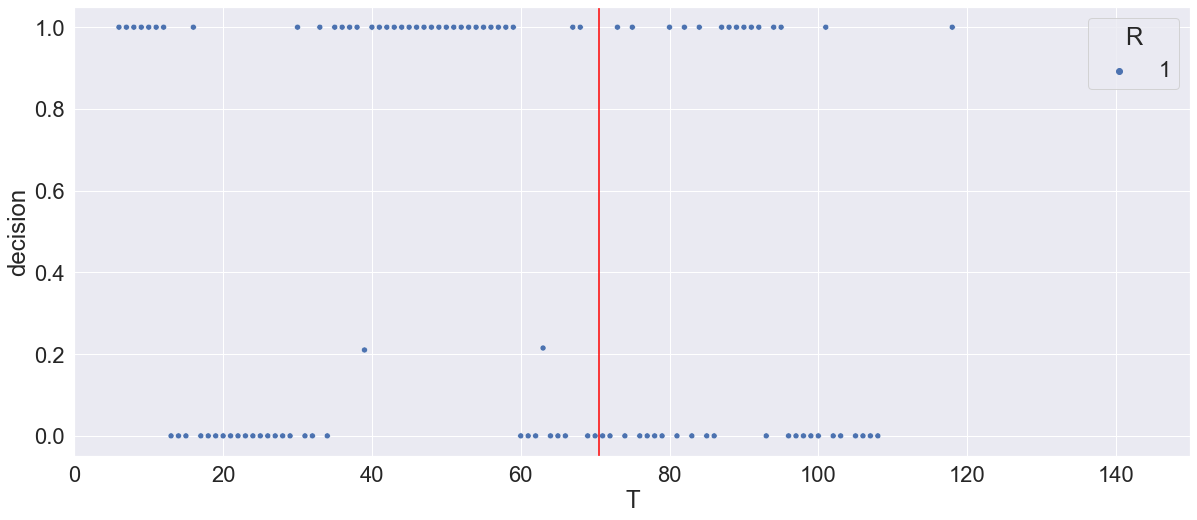

In [35]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


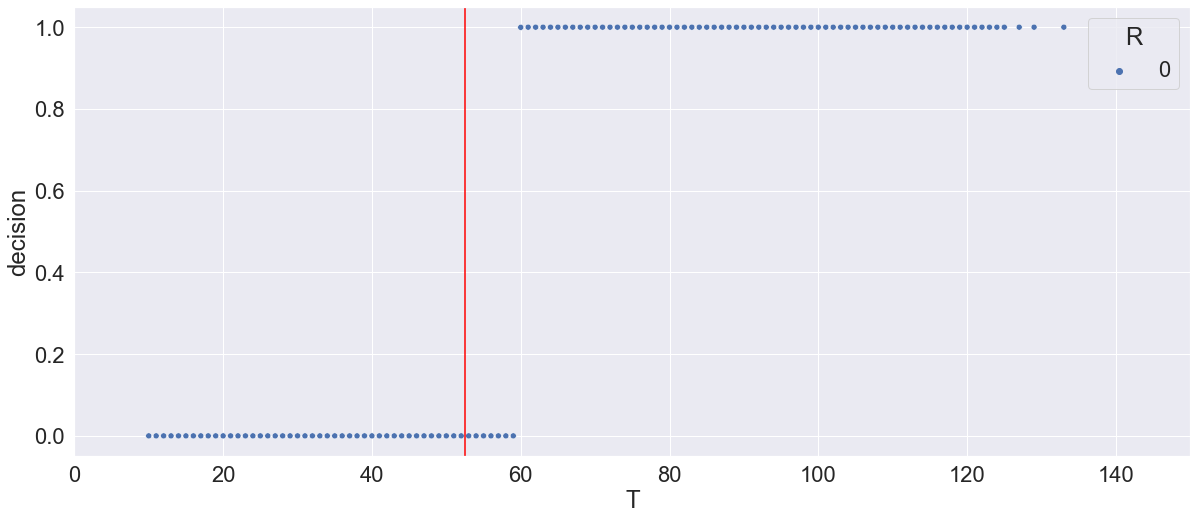

In [36]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [37]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.380076
1,0.395198


In [38]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5328841785118432', '246476.2836799999')

In [39]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

A    0.50815
dtype: float64

In [40]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5328841785118432', '246476.2836799999')

In [41]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.5056847578642384

In [42]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

312122.07069596456

In [43]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

246476.2836799999

In [44]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

234573

In [45]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

A    0.50815
dtype: float64

In [46]:
(admit_decisions['decision'].sum())

485046.0000000001

In [47]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.380086
1,0.380258
